In [1]:
!git clone https://github.com/riya21parikh/CarInBikeLane.git

Cloning into 'CarInBikeLane'...
remote: Enumerating objects: 4190, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 4190 (delta 1), reused 0 (delta 0), pack-reused 4181 (from 2)
Receiving objects: 100% (4190/4190), 852.95 MiB | 16.37 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Updating files: 100% (4386/4386), done.


In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
import keras
from keras import layers, models
from keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time
import PIL
from tqdm import tqdm
import pandas as pd
import re
import random, shutil
import glob
import torch

In [3]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [4]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Data pre-processing

## Loading and concatenating + removing duplicates/corrupted images

In [5]:
root = "/content/CarInBikeLane/Method1/data/data"
root2 = "/content/CarInBikeLane/Method1/data/data2"
root3 = "/content/CarInBikeLane/Method2/Bikelanes"

# Load all data
blocked2 = os.path.join(root, "blocked2")
blocked3 = os.path.join(root2, "blocked3")

notblocked2 = os.path.join(root, "notblocked2")
notblocked3 = os.path.join(root2, "notblocked3")

blocked = os.path.join(root3, "blocked")
notblocked = os.path.join(root3, "notblocked")

# concatenate them
blocked_folders = [
    os.path.join(root, "blocked2"),
    os.path.join(root2, "blocked3"),
    os.path.join(root3, "blocked"),
]

notblocked_folders = [
    os.path.join(root, "notblocked2"),
    os.path.join(root2, "notblocked3"),
    os.path.join(root3, "notblocked"),
]

blocked_files = []
notblocked_files = []

for folder in blocked_folders:
    blocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

for folder in notblocked_folders:
    notblocked_files += [os.path.join(folder, f) for f in os.listdir(folder)]

print("Total blocked images: ", len(blocked_files))
print("Total unblocked images: ", len(notblocked_files))

Total blocked images:  2351
Total unblocked images:  1831


In [6]:
def remove_duplicates(file_list):
    seen = set()
    unique = []
    for f in file_list:
        name = os.path.basename(f)
        if name not in seen:
            seen.add(name)
            unique.append(f)
    return unique

def corrupted(path):
    try:
        img = PIL.Image.open(path)
        img.verify()
        return False
    except:
        return True

In [7]:
blocked_files = remove_duplicates(blocked_files)
notblocked_files = remove_duplicates(notblocked_files)

print("Total blocked images (no duplicates): ", len(blocked_files))
print("Total unblocked images (no duplicates): ", len(notblocked_files))

bad = []

for f in tqdm(blocked_files + notblocked_files):
    if corrupted(f):
        bad.append(f)

print("\n")
print("corrupted files:", len(bad))

Total blocked images (no duplicates):  2231
Total unblocked images (no duplicates):  1721


100%|██████████| 3952/3952 [00:01<00:00, 2157.45it/s]



corrupted files: 0


## Data splitting (into folders to be used by models)

### Randomly 70/15/15

In [8]:
BASE = "/content/split_random"

classes = ["blocked", "notblocked"]

if os.path.exists(BASE):
    shutil.rmtree(BASE)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(BASE, split, cls), exist_ok=True)

def random_split(files, train_ratio=0.7, val_ratio=0.15):

    random.seed(42)
    random.shuffle(files)

    n = len(files)
    n_train = int(train_ratio * n)
    n_val   = int(val_ratio * n)

    train = files[:n_train]
    val   = files[n_train:n_train+n_val]
    test  = files[n_train+n_val:]

    return train, val, test


train_blocked, val_blocked, test_blocked = random_split(blocked_files)
train_notblocked, val_notblocked, test_notblocked = random_split(notblocked_files)

for f in train_blocked:
    shutil.copy(f, os.path.join(BASE, "train/blocked"))
for f in train_notblocked:
    shutil.copy(f, os.path.join(BASE, "train/notblocked"))

for f in val_blocked:
    shutil.copy(f, os.path.join(BASE, "val/blocked"))
for f in val_notblocked:
    shutil.copy(f, os.path.join(BASE, "val/notblocked"))

for f in test_blocked:
    shutil.copy(f, os.path.join(BASE, "test/blocked"))
for f in test_notblocked:
    shutil.copy(f, os.path.join(BASE, "test/notblocked"))

print("DONE!")
print("Dataset ready at:", BASE)

DONE!
Dataset ready at: /content/split_random


### Split by camera (test only on camera 68 and 70/30 split for train/val)

In [9]:
BASE = "/content/split_camera"

classes = ["blocked", "notblocked"]

if os.path.exists(BASE):
    shutil.rmtree(BASE)

for split in ["train", "val", "test"]:
    for cls in classes:
        os.makedirs(os.path.join(BASE, split, cls), exist_ok=True)


def is_cam68(path):
    return "cam68" in os.path.basename(path)


test_blocked      = [f for f in blocked_files if is_cam68(f)]
test_notblocked   = [f for f in notblocked_files if is_cam68(f)]

blocked_remaining     = [f for f in blocked_files if f not in test_blocked]
notblocked_remaining  = [f for f in notblocked_files if f not in test_notblocked]


def split_70_30(files):
    random.seed(42)
    random.shuffle(files)
    n = len(files)
    n_train = int(0.7 * n)
    train = files[:n_train]
    val   = files[n_train:]
    return train, val


train_blocked, val_blocked = split_70_30(blocked_remaining)
train_notblocked, val_notblocked = split_70_30(notblocked_remaining)


for f in train_blocked:
    shutil.copy(f, os.path.join(BASE, "train/blocked"))
for f in train_notblocked:
    shutil.copy(f, os.path.join(BASE, "train/notblocked"))

for f in val_blocked:
    shutil.copy(f, os.path.join(BASE, "val/blocked"))
for f in val_notblocked:
    shutil.copy(f, os.path.join(BASE, "val/notblocked"))

for f in test_blocked:
    shutil.copy(f, os.path.join(BASE, "test/blocked"))
for f in test_notblocked:
    shutil.copy(f, os.path.join(BASE, "test/notblocked"))


print("DONE!")
print("Dataset created at:", BASE)
print()
print("blocked: train",len(train_blocked), "val",len(val_blocked), "test",len(test_blocked))
print("notblocked: train",len(train_notblocked), "val",len(val_notblocked), "test",len(test_notblocked))

DONE!
Dataset created at: /content/split_camera

blocked: train 1554 val 666 test 11
notblocked: train 1185 val 509 test 27


## Images as Arrays of RGB (if needed)

In [10]:
images = []
labels = []

print("Loading blocked images")
for img_path in blocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(1)

print("Loading notblocked images")
for img_path in notblocked_files:
    img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    img_array = img_to_array(img)
    images.append(img_array)
    labels.append(0)

X = np.array(images)
y = np.array(labels)

X = X / 255.0

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

print("Train:", X_train.shape)
print("Val:",   X_val.shape)
print("Test:",  X_test.shape)

Loading blocked images
Loading notblocked images
Train: (2766, 224, 224, 3)
Val: (593, 224, 224, 3)
Test: (593, 224, 224, 3)


**Final data**:

- *blocked_files* and *notblocked_files* are lists of the full path to the images
- *split_random* is a folder that splits the previous lists of images into train/val/test randomly, separated between class
- *split_camera* is a folder that splits the previous lists of images into train/val/test by separating images from Cam68 into test and all other cameras into train/val
- *X_train, X_val, X_test, y_train, y_val* and *y_test* is a split of the data that was previously converted into arrays of 224x224 RGB (not used in baseline)

# Model 1: DeepLabv3

Part 1: Creating masks for a training data of 30 images (from all cameras)

In [11]:
import json
import numpy as np
import cv2
from PIL import Image


def mask_from_makesense_json(data, filename, image_path, class_name="Bikelane"):

    # Load the image to get height and width
    img = np.array(Image.open(image_path))
    h, w = img.shape[:2]

    # create empty mask
    mask = np.zeros((h, w), dtype=np.uint8)

    # find annotation entry
    entry = data[filename]

    # regions dict has numbered keys
    for region_id, region in entry["regions"].items():

        if region["region_attributes"].get("label") == class_name:

            xs = region["shape_attributes"]["all_points_x"]
            ys = region["shape_attributes"]["all_points_y"]

            pts = np.array(list(zip(xs, ys)), dtype=np.int32)

            cv2.fillPoly(mask, [pts], 1)

    return mask, img

In [12]:
list_files = ["2016-09-16 151457 cam135.png", "2016-09-16 151625 cam31.png", "2016-09-16 152433 cam182.png",
              "2016-09-16 153711 cam68.png", "2016-09-16 153711 cam135.png",
              "2016-09-16 160037 cam135.png", "2016-09-18 104352 cam135.png", "2016-09-18 111422 cam135.png",
              "2016-09-18 132707 cam135.png", "2016-09-18 133616 cam135.png", "2016-09-21 071138 cam135.png",
              "2016-09-21 081036 cam135.png", "2016-09-21 082248 cam135.png", "2016-09-21 090745 cam135.png",
              "2016-09-21 093108 cam135.png", "2016-09-21 122805 cam135.png", "2016-09-21 175940 cam135.png",
              "2016-09-22 091506 cam135.png", "2016-09-22 093324 cam135.png", "2016-09-28 142020 cam135.png",
              "2016-09-28 160852 cam135.png", "2016-09-28 163013 cam135.png", "2016-09-28 191706 cam135.png",
              "2016-10-05 111540 cam135.png", "2016-10-05 113156 cam135.png", "2016-10-05 115217 cam135.png",
              "2016-10-05 164117 cam135.png", "2016-10-12 203443 cam135.png", "2016-10-12 214142 cam135.png",
              "2016-10-12 223535 cam135.png"]

ROOT = "/content/CarInBikeLane"

all_imgs = glob.glob(ROOT + "/**/*.png", recursive=True)

sampled_files = []

for name in list_files:
    matches = [p for p in all_imgs if p.endswith(name)]
    if len(matches):
        sampled_files.append(matches[0])
    else:
        print("Missing:", name)

In [13]:
SAVE_ROOT = "/content/deeplab_dataset"

IMG_SAVE_DIR  = f"{SAVE_ROOT}/images"
MSK_SAVE_DIR  = f"{SAVE_ROOT}/masks"

json_path = "/content/CarInBikeLane/baseline_masks.json"

os.makedirs(IMG_SAVE_DIR, exist_ok=True)
os.makedirs(MSK_SAVE_DIR, exist_ok=True)

with open(json_path,'r') as f:
    data = json.load(f)

saved = 0

for full_path in tqdm(sampled_files):

    fname = os.path.basename(full_path)

    mask, img = mask_from_makesense_json(data, fname, full_path)

    if mask.max() != 1:
        continue

    shutil.copy(full_path, f"{IMG_SAVE_DIR}/{fname}")

    mask_png = Image.fromarray((mask*255).astype(np.uint8))
    mask_png.save(f"{MSK_SAVE_DIR}/{fname}")

    saved += 1

100%|██████████| 30/30 [00:00<00:00, 187.17it/s]


Part 2: Train the model

In [14]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
import torchvision
import torch.nn as nn
import torch.optim as optim

class BikeLaneSegDataset(Dataset):
    def __init__(self, root, size=512):
        self.img_dir = os.path.join(root, "images")
        self.mask_dir = os.path.join(root, "masks")

        self.images = sorted(os.listdir(self.img_dir))

        self.im_tf = T.Compose([
            T.Resize((size,size)),
            T.ToTensor(),
        ])

        self.mask_tf = T.Compose([
            T.Resize((size,size), interpolation=Image.NEAREST),
            T.ToTensor(),
        ])

    def __getitem__(self, idx):
        img_name = self.images[idx]

        img = Image.open(os.path.join(self.img_dir,img_name)).convert("RGB")
        mask = Image.open(os.path.join(self.mask_dir,img_name)).convert("L")

        img = self.im_tf(img)
        mask = self.mask_tf(mask)
        mask = (mask>0.5).float()   # force 0/1

        return img, mask

    def __len__(self):
        return len(self.images)


dataset = BikeLaneSegDataset("/content/deeplab_dataset", size=512)

In [15]:
import random

# All image names from dataset
all_images = dataset.images

# Extract camera code from filename
def get_camera(fname):
    return fname.split()[-1].replace(".png","")

# Group images by camera
cam135 = [f for f in all_images if "cam135" in f]
cam182 = [f for f in all_images if "cam182" in f]
cam31  = [f for f in all_images if "cam31"  in f]
cam68  = [f for f in all_images if "cam68"  in f]

rare = cam182 + cam31 + cam68

random.seed(42)

test_rare = random.sample(rare, 2)

test_135  = random.sample(cam135, 3)

test_files = test_rare + test_135

print("Test set:")
for f in test_files:
    print("   ", f)

remaining = [f for f in all_images if f not in test_files]

random.shuffle(remaining)

N_train = int(0.70 * len(all_images))
N_val   = int(0.15 * len(all_images))

train_files = remaining[:N_train]
val_files   = remaining[N_train:N_train + N_val]

train_files += [f for f in remaining if f not in train_files and f not in val_files]

print("\nTrain:", len(train_files))
print("Val:", len(val_files))
print("Test:", len(test_files))
def to_indices(file_list):
    return [all_images.index(f) for f in file_list]

train_indices = to_indices(train_files)
val_indices   = to_indices(val_files)
test_indices  = to_indices(test_files)

from torch.utils.data import Subset
train_ds = Subset(dataset, train_indices)
val_ds   = Subset(dataset, val_indices)
test_ds  = Subset(dataset, test_indices)

train_loader = DataLoader(train_ds, batch_size=3, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=2)

model = torchvision.models.segmentation.deeplabv3_resnet50(weights="DEFAULT")

model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

model = model.cuda()

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

Test set:
    2016-09-16 153711 cam68.png
    2016-09-16 152433 cam182.png
    2016-09-16 151457 cam135.png
    2016-10-05 164117 cam135.png
    2016-09-21 081036 cam135.png

Train: 21
Val: 4
Test: 5
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 245MB/s]


In [16]:
for epoch in range(20):

    model.train()
    for img,mask in train_loader:
        img = img.cuda()
        mask = mask.cuda()

        optimizer.zero_grad()
        pred = model(img)["out"]
        loss = criterion(pred, mask)

        loss.backward()
        optimizer.step()

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for img,mask in val_loader:
            img = img.cuda()
            mask = mask.cuda()
            pred = model(img)["out"]
            val_loss += criterion(pred, mask).item()

    print(f"epoch {epoch+1}  train_loss={loss.item():.4f}   val_loss={val_loss/len(val_loader):.4f}")

torch.save(model.state_dict(), "/content/deeplab_bikelane.pth")

epoch 1  train_loss=0.6624   val_loss=0.7767
epoch 2  train_loss=0.5893   val_loss=0.7972
epoch 3  train_loss=0.5114   val_loss=0.6024
epoch 4  train_loss=0.4210   val_loss=0.4959
epoch 5  train_loss=0.3774   val_loss=0.4076
epoch 6  train_loss=0.3236   val_loss=0.3479
epoch 7  train_loss=0.3032   val_loss=0.3080
epoch 8  train_loss=0.2900   val_loss=0.2925
epoch 9  train_loss=0.2885   val_loss=0.2542
epoch 10  train_loss=0.2732   val_loss=0.2463
epoch 11  train_loss=0.2468   val_loss=0.2433
epoch 12  train_loss=0.2527   val_loss=0.2312
epoch 13  train_loss=0.2303   val_loss=0.2287
epoch 14  train_loss=0.2206   val_loss=0.2201
epoch 15  train_loss=0.2239   val_loss=0.2105
epoch 16  train_loss=0.2087   val_loss=0.2057
epoch 17  train_loss=0.2102   val_loss=0.2045
epoch 18  train_loss=0.1948   val_loss=0.2174
epoch 19  train_loss=0.1895   val_loss=0.1928
epoch 20  train_loss=0.1828   val_loss=0.2013


Part 3: Evaluate the model on the test data (5 images)

In [17]:
test_loader  = DataLoader(test_ds, batch_size=1, shuffle=False)
ious = []
device = "cuda" if torch.cuda.is_available() else "cpu"

def iou_score(pred, mask):
    intersection = np.logical_and(pred==1, mask==1).sum()
    union        = np.logical_or (pred==1, mask==1).sum()
    if union == 0:
        return np.nan
    return intersection / union

model.eval()
with torch.no_grad():
    for imgs, masks in test_loader:
        imgs = imgs.to(device)
        masks = masks.to(device).float()

        logits = model(imgs)["out"]
        probs = torch.sigmoid(logits)

        pred = (probs[0,0] > 0.5).cpu().numpy()
        mask = masks[0,0].cpu().numpy()

        iou = iou_score(pred, mask)
        ious.append(iou)

import numpy as np
print("Mean IoU:", np.nanmean(ious))
print("Median IoU:", np.nanmedian(ious))
print("Std IoU:", np.nanstd(ious))

Mean IoU: 0.461198782295461
Median IoU: 0.6915247964470762
Std IoU: 0.37749301639531346


Part 4: Inspect model on the rest of the dataset

In [18]:
import torch
import torchvision
import torch.nn as nn

model = torchvision.models.segmentation.deeplabv3_resnet50(weights=None)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)

state = torch.load("/content/deeplab_bikelane.pth", map_location="cpu")
model.load_state_dict(state, strict=False)
model = model.cuda()
model.eval()

pred_tf = T.Compose([
    T.Resize((512,512)),
    T.ToTensor(),
])


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 230MB/s]


In [19]:
def predict_mask(image_path):
    img = Image.open(image_path).convert("RGB")
    t = pred_tf(img).unsqueeze(0).cuda()

    with torch.no_grad():
        pred = model(t)["out"]
        mask = torch.sigmoid(pred)[0,0]
        mask = (mask > 0.5).float()

    mask = mask.cpu().numpy()
    return img, mask

def resize_mask(mask, img):
    h, w = img.size[1], img.size[0]
    mask_resized = cv2.resize(mask.astype(np.float32), (w,h), interpolation=cv2.INTER_NEAREST)
    return mask_resized

def show_overlay(img, mask, alpha=0.45):

    img_np = np.array(img)

    mask_resized = resize_mask(mask, img)

    mask_rgb = np.zeros_like(img_np)
    mask_rgb[:,:,0] = (mask_resized * 255).astype(np.uint8)

    overlay = img_np.copy()
    overlay = (overlay * (1-alpha) + mask_rgb * alpha).astype(np.uint8)

    plt.figure(figsize=(8,8))
    plt.imshow(overlay)
    plt.title("Predicted Bike Lane Overlay")
    plt.axis("off")
    plt.show()

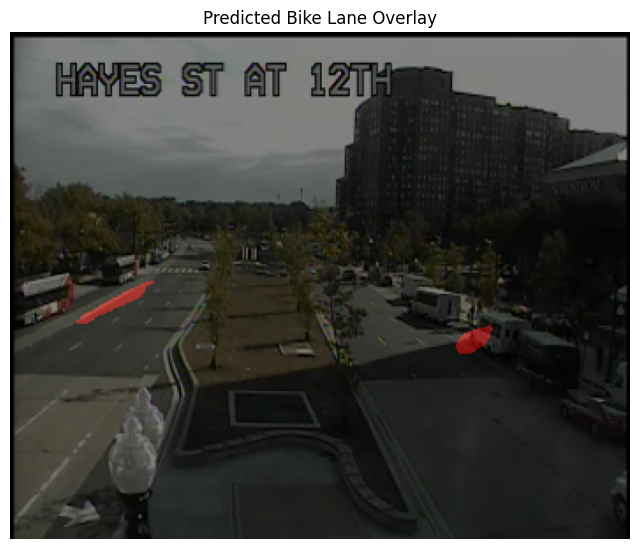

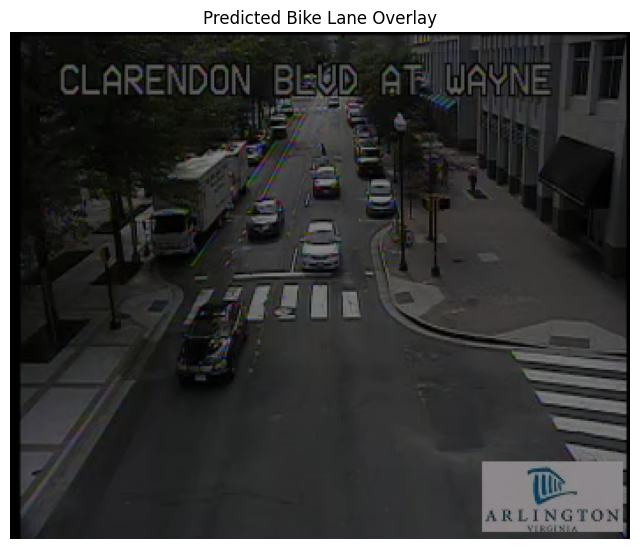

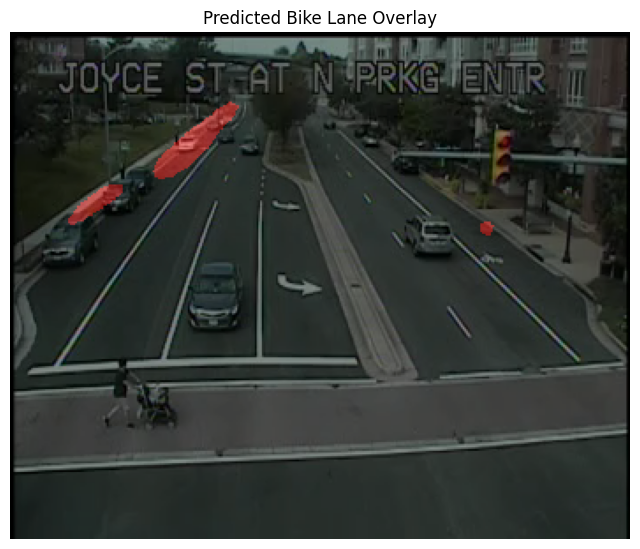

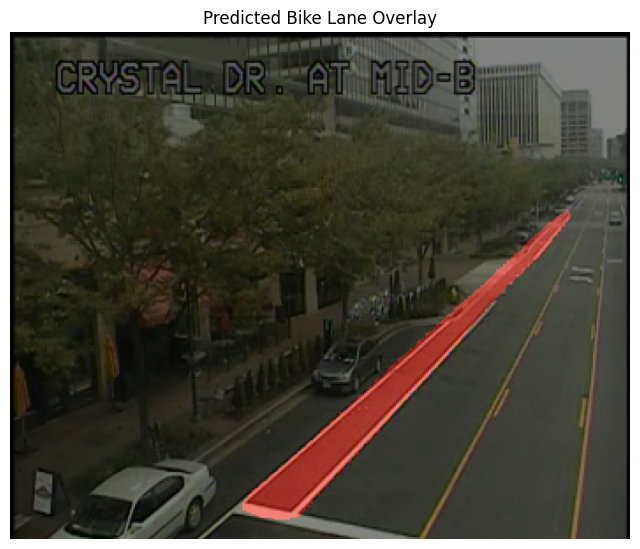

In [20]:
images = ["/content/CarInBikeLane/Method1/data/data2/notblocked3/2016-09-16 155933 cam31.png",
          "/content/CarInBikeLane/Method1/data/data2/blocked3/2016-09-16 153509 cam68.png",
          "/content/CarInBikeLane/Method1/data/data2/notblocked3/2016-09-16 151036 cam182.png",
          "/content/CarInBikeLane/Method1/data/data/notblocked2/2016-09-18 082154 cam135.png"]

for image in images :
  if image not in sampled_files:
    img, pred_mask = predict_mask(image)
    show_overlay(img, pred_mask)
  else: print("In training sample")

# Model 2: Yolov8

In [25]:
!pip install --upgrade ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 20.0 MB/s eta 0:00:00


In [26]:
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


## Method 1: Vehicle Detection

In [27]:
import yaml
import torch
PATH = "/content/yolov8-detection"
VEHICLE_CLASSES = [2, 3, 5, 7]
SPLITS = ["train", "val"]

for split in SPLITS:
    os.makedirs(f"{PATH}/images/{split}", exist_ok=True)
    os.makedirs(f"{PATH}/labels/{split}", exist_ok=True)

all_imgs = blocked_files + notblocked_files

train_imgs, temp_imgs = train_test_split(
    all_imgs, test_size=0.30, random_state=42
)
val_imgs, test_imgs = train_test_split(
    temp_imgs, test_size=0.50, random_state=42
)

def copy_to_split(img_paths, split_name):
    for img_path in img_paths:
        fname = os.path.basename(img_path)
        shutil.copy(img_path, f"{PATH}/images/{split_name}/{fname}")

copy_to_split(train_imgs, "train")
copy_to_split(val_imgs, "val")

labeling_model = YOLO('yolov8n.pt')

for split in SPLITS:
    img_dir = f"{PATH}/images/{split}"
    lbl_dir = f"{PATH}/labels/{split}"
    img_list = sorted(os.listdir(img_dir))

    for fname in tqdm(img_list):
        img_path = os.path.join(img_dir, fname)
        results = labeling_model(img_path, conf=0.5)

        boxes = results[0].boxes
        if boxes is None:
            label_path = os.path.join(lbl_dir, fname.rsplit(".", 1)[0] + ".txt")
            open(label_path, "w").close()
            continue

        cls = boxes.cls.cpu().numpy()
        xyxy = boxes.xyxy.cpu().numpy()
        conf = boxes.conf.cpu().numpy()

        label_path = os.path.join(lbl_dir, fname.rsplit(".", 1)[0] + ".txt")

        with open(label_path, 'w') as f:
            for i, class_id in enumerate(cls):
                if int(class_id) in VEHICLE_CLASSES and conf[i] > 0.5:
                    x1, y1, x2, y2 = xyxy[i]

                    xc = ((x1 + x2) / 2) / results[0].orig_shape[1]
                    yc = ((y1 + y2) / 2) / results[0].orig_shape[0]
                    w = (x2 - x1) / results[0].orig_shape[1]
                    h = (y2 - y1) / results[0].orig_shape[0]

                    if 0 <= xc <= 1 and 0 <= yc <= 1 and 0 < w <= 1 and 0 < h <= 1:
                        f.write(f"0 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")

del labeling_model
torch.cuda.empty_cache()

dataset_yaml = {
    'path': PATH,
    'train': 'images/train',
    'val': 'images/val',
    'test': 'images/test',
    'names': {0: 'vehicle'},
    'nc': 1
}

with open("/content/yolov8-detection.yaml", "w") as f:
    yaml.dump(dataset_yaml, f)

print("Dataset YAML created at /content/yolov8-detection.yaml")

# Check a few label files to ensure quality
for split in SPLITS:
    lbl_dir = f"{PATH}/labels/{split}"
    label_files = [f for f in os.listdir(lbl_dir) if f.endswith('.txt')][:3]
    for lbl_file in label_files:
        lbl_path = os.path.join(lbl_dir, lbl_file)
        with open(lbl_path, 'r') as f:
            lines = f.readlines()
            print(f"  {lbl_file}: {len(lines)} vehicles")


print("Training from scratch...")
model = YOLO('yolov8n.yaml')

results = model.train(
    data="/content/yolov8-detection.yaml",
    epochs=20,
    imgsz=640,
    batch=8,
    lr0=0.01,
    patience=10,
    device=0 if torch.cuda.is_available() else 'cpu',
    pretrained=False,
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=10,
    translate=0.1,
    scale=0.5,
    fliplr=0.5
)


  0%|          | 0/2766 [00:00<?, ?it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 150825 cam135.png: 544x640 2 cars, 1 bus, 70.8ms
Speed: 8.0ms preprocess, 70.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


  0%|          | 1/2766 [00:00<31:06,  1.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 150825 cam31.png: 544x640 3 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 5.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 150825 cam68.png: 544x640 1 car, 2 buss, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 150926 cam31.png: 544x640 5 cars, 1 parking meter, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151036 cam31.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151137 cam135.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at 

  0%|          | 8/2766 [00:00<03:29, 13.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151137 cam68.png: 544x640 2 persons, 1 bus, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151238 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151238 cam182.png: 544x640 1 car, 1 bus, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151457 cam135.png: 544x640 2 cars, 2 buss, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151457 cam182.png: 544x640 3 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference

  1%|          | 15/2766 [00:00<01:54, 24.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151625 cam31.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151625 cam68.png: 544x640 1 person, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151726 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151726 cam182.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151726 cam68.png: 544x640 1 person, 1 car, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess

  1%|          | 22/2766 [00:01<01:22, 33.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 151827 cam31.png: 544x640 1 car, 1 parking meter, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151827 cam68.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151928 cam182.png: 544x640 4 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151928 cam31.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 151928 cam68.png: 544x640 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape 

  1%|          | 29/2766 [00:01<01:06, 41.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152029 cam68.png: 544x640 1 person, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam182.png: 544x640 4 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam31.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152130 cam68.png: 544x640 1 person, 1 car, 2 buss, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per im

  1%|▏         | 36/2766 [00:01<00:57, 47.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152231 cam68.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam135.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam182.png: 544x640 2 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam31.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152332 cam68.png: 544x640 1 bus, 1 traffic light, 7.5ms
Speed: 2.6ms preprocess, 7.5ms inference, 1.1ms postprocess per image 

  2%|▏         | 43/2766 [00:01<00:52, 52.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 152433 cam31.png: 544x640 4 cars, 1 bus, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152534 cam135.png: 544x640 1 bus, 1 truck, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152534 cam182.png: 544x640 4 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152534 cam31.png: 544x640 3 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 152635 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per imag

  2%|▏         | 50/2766 [00:01<00:49, 55.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153004 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153004 cam182.png: 544x640 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153004 cam31.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153105 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153105 cam182.png: 544x640 2 traffic lights, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544

  2%|▏         | 57/2766 [00:01<00:46, 58.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153206 cam68.png: 544x640 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam182.png: 544x640 1 car, 2 traffic lights, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam31.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153307 cam68.png: 544x640 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 5

  2%|▏         | 64/2766 [00:01<00:44, 60.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153408 cam68.png: 544x640 1 person, 2 buss, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153509 cam135.png: 544x640 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153509 cam182.png: 544x640 1 car, 1 traffic light, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153509 cam31.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153610 cam31.png: 544x640 2 cars, 1 bus, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.0ms postprocess pe

  3%|▎         | 71/2766 [00:01<00:43, 62.66it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 153812 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 153913 cam182.png: 544x640 2 cars, 2 traffic lights, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154014 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154014 cam182.png: 544x640 2 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154014 cam31.png: 544x640 2 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms pos

  3%|▎         | 78/2766 [00:01<00:42, 63.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154115 cam31.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154115 cam68.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154216 cam135.png: 544x640 2 persons, 5 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154216 cam31.png: 544x640 3 cars, 2 buss, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154216 cam68.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per im

  3%|▎         | 85/2766 [00:01<00:41, 64.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154519 cam68.png: 544x640 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154620 cam135.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154620 cam31.png: 544x640 1 car, 2 buss, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154721 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 154822 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess p

  3%|▎         | 92/2766 [00:02<00:41, 64.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 154923 cam68.png: 544x640 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155125 cam182.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155125 cam31.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155125 cam68.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155226 cam182.png: 544x640 1 car, 2 traffic lights, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postproces

  4%|▎         | 99/2766 [00:02<00:41, 64.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155327 cam182.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155330 cam135.png: 544x640 3 cars, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155428 cam182.png: 544x640 4 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155431 cam135.png: 544x640 3 cars, 3 buss, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155529 cam182.png: 544x640 4 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms 

  4%|▍         | 106/2766 [00:02<00:41, 64.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155630 cam182.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155633 cam135.png: 544x640 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155731 cam182.png: 544x640 2 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155734 cam135.png: 544x640 5 cars, 1 bus, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155832 cam182.png: 544x640 1 car, 1 bus, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 

  4%|▍         | 113/2766 [00:02<00:41, 64.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 155835 cam135.png: 544x640 2 cars, 2 buss, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155933 cam31.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 155936 cam135.png: 544x640 3 cars, 2 buss, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160037 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160138 cam135.png: 544x640 1 bus, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per imag

  4%|▍         | 120/2766 [00:02<00:41, 64.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 160542 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160845 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 160946 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161047 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161148 cam135.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape 

  5%|▍         | 127/2766 [00:02<00:40, 64.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 161552 cam135.png: 544x640 2 persons, 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161653 cam135.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161754 cam135.png: 544x640 4 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161855 cam135.png: 544x640 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 161956 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at s

  5%|▍         | 134/2766 [00:02<00:40, 64.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 162400 cam135.png: 544x640 2 cars, 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162501 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162703 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 162804 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163006 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at 

  5%|▌         | 141/2766 [00:02<00:41, 63.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-16 163309 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163410 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 163915 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 164218 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-16 164521 cam135.png: 544x640 1 person, 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at

  5%|▌         | 148/2766 [00:02<00:40, 64.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 070316 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070417 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070518 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070619 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 070720 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess p

  6%|▌         | 156/2766 [00:03<00:39, 66.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 071124 cam135.png: 544x640 (no detections), 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071226 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071327 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071428 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 071630 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess p

  6%|▌         | 164/2766 [00:03<00:38, 67.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 072135 cam135.png: 544x640 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072236 cam135.png: 544x640 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072337 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072539 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 072741 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess p

  6%|▌         | 171/2766 [00:03<00:38, 68.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 073037 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073138 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073239 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073340 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073441 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess p

  6%|▋         | 179/2766 [00:03<00:37, 68.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 073845 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 073946 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074047 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074148 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 074350 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess p

  7%|▋         | 186/2766 [00:03<00:37, 68.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 074956 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075057 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075158 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075501 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 075602 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess p

  7%|▋         | 194/2766 [00:03<00:36, 69.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 080208 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080309 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080410 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080713 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 080814 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1

  7%|▋         | 201/2766 [00:03<00:36, 69.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 081144 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081245 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081346 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081447 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 081548 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

imag

  8%|▊         | 208/2766 [00:03<00:37, 68.69it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 081952 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082053 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082154 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082255 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082356 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image a

  8%|▊         | 215/2766 [00:03<00:37, 68.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 082800 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 082901 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083002 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083103 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083204 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

  8%|▊         | 222/2766 [00:04<00:37, 67.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 083709 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 083911 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084113 cam135.png: 544x640 2 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084214 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084315 cam135.png: 544x640 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (

  8%|▊         | 229/2766 [00:04<00:37, 67.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 084618 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084719 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084820 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 084921 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085022 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

  9%|▊         | 236/2766 [00:04<00:38, 65.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 085426 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085830 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 085931 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090133 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090436 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

  9%|▉         | 243/2766 [00:04<00:38, 64.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 090739 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 090941 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091143 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091222 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091323 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

  9%|▉         | 250/2766 [00:04<00:38, 64.73it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 091828 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 091929 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092232 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092333 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092434 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

  9%|▉         | 257/2766 [00:04<00:38, 64.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 092838 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 092939 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093040 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093141 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093242 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 10%|▉         | 264/2766 [00:04<00:38, 65.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 093545 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093646 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093747 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 093949 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094050 cam135.png: 544x640 3 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 10%|▉         | 271/2766 [00:04<00:38, 65.44it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 094353 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094454 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094555 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094656 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 094858 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 10%|█         | 278/2766 [00:04<00:38, 65.47it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 095504 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095605 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095706 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 095807 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100211 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 10%|█         | 285/2766 [00:04<00:37, 66.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 100514 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100615 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100716 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100817 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 100918 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 11%|█         | 292/2766 [00:05<00:37, 65.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 101625 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101726 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 101928 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102130 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 102231 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 11%|█         | 299/2766 [00:05<00:37, 65.52it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 102837 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103039 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103241 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103342 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 103443 cam135.png: 544x640 1 person, 1 umbrella, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 

 11%|█         | 306/2766 [00:05<00:37, 65.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 103746 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104049 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104352 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104453 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 104554 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 11%|█▏        | 313/2766 [00:05<00:37, 65.66it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 104958 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105059 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105200 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105301 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 105503 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 54

 12%|█▏        | 320/2766 [00:05<00:37, 65.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 110109 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110311 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110513 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 110917 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111018 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 12%|█▏        | 327/2766 [00:05<00:37, 65.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 111422 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111523 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111624 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 111927 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112331 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 12%|█▏        | 334/2766 [00:05<00:37, 65.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 112735 cam135.png: 544x640 1 person, 2 cars, 6.3ms
Speed: 2.3ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112836 cam135.png: 544x640 1 person, 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 112937 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113341 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113442 cam135.png: 544x640 3 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 

 12%|█▏        | 341/2766 [00:05<00:36, 65.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 113745 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 113846 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114048 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114149 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114351 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 13%|█▎        | 348/2766 [00:05<00:36, 65.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 114654 cam135.png: 544x640 3 cars, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114755 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114856 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 114957 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115058 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 13%|█▎        | 355/2766 [00:06<00:36, 65.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 115502 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115603 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115704 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115805 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 115906 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 13%|█▎        | 362/2766 [00:06<00:36, 65.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 120310 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120613 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120815 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 120916 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121017 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 13%|█▎        | 369/2766 [00:06<00:36, 65.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 121724 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121825 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 121926 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122128 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122229 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 14%|█▎        | 376/2766 [00:06<00:36, 65.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 122633 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122734 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122835 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 122936 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123037 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 14%|█▍        | 383/2766 [00:06<00:36, 65.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 123340 cam135.png: 544x640 1 train, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123441 cam135.png: 544x640 3 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123643 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123744 cam135.png: 544x640 1 train, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 123845 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

 14%|█▍        | 390/2766 [00:06<00:35, 66.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 124552 cam135.png: 544x640 1 person, 1 train, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124653 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124754 cam135.png: 544x640 1 train, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124855 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 124956 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at sh

 14%|█▍        | 397/2766 [00:06<00:35, 66.52it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 125259 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125400 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125602 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 125905 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130107 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image a

 15%|█▍        | 404/2766 [00:06<00:35, 67.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 130612 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130713 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130814 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 130915 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131016 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image a

 15%|█▍        | 411/2766 [00:06<00:34, 67.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 131319 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131521 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131622 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131824 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 131925 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 

 15%|█▌        | 418/2766 [00:06<00:34, 67.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 132531 cam135.png: 544x640 2 trains, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132707 cam135.png: 544x640 2 trains, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132808 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 132909 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133010 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 

 15%|█▌        | 425/2766 [00:07<00:34, 67.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 133313 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133515 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133616 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 133919 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134020 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 54

 16%|█▌        | 432/2766 [00:07<00:35, 66.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 134828 cam135.png: 544x640 1 person, 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 134929 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135030 cam135.png: 544x640 2 trains, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135131 cam135.png: 544x640 1 train, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135333 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 16%|█▌        | 439/2766 [00:07<00:35, 66.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 135838 cam135.png: 544x640 1 train, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 135939 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140040 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140141 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140242 cam135.png: 544x640 1 boat, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 16%|█▌        | 446/2766 [00:07<00:35, 65.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 140545 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140646 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140747 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140848 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 140949 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess p

 16%|█▋        | 453/2766 [00:07<00:34, 66.69it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 141252 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141353 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141454 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141555 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 141656 cam135.png: 544x640 (no detections), 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 0.5ms postprocess per image

 17%|█▋        | 460/2766 [00:07<00:34, 66.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 142100 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142504 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142706 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 142807 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143009 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (

 17%|█▋        | 467/2766 [00:07<00:34, 67.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 143413 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143514 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143615 cam135.png: 544x640 (no detections), 6.4ms
Speed: 2.7ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143716 cam135.png: 544x640 2 cars, 1 umbrella, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 143817 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.6ms postprocess per image at shap

 17%|█▋        | 474/2766 [00:07<00:34, 66.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 144221 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144322 cam135.png: 544x640 2 cars, 1 traffic light, 7.3ms
Speed: 2.3ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144524 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144625 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 144726 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at 

 17%|█▋        | 481/2766 [00:07<00:35, 64.74it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-18 145130 cam135.png: 544x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-18 145231 cam135.png: 544x640 1 car, 8.5ms
Speed: 2.5ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070027 cam135.png: 544x640 1 person, 8.3ms
Speed: 1.9ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070128 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070229 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 54

 18%|█▊        | 488/2766 [00:08<00:35, 64.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 070532 cam135.png: 544x640 1 truck, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070633 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070734 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070835 cam135.png: 544x640 1 person, 1 truck, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 070936 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape

 18%|█▊        | 495/2766 [00:08<00:36, 63.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 071239 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071340 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.6ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071441 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071542 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 071643 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per

 18%|█▊        | 502/2766 [00:08<00:35, 64.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 072148 cam135.png: 544x640 2 persons, 3 cars, 1 truck, 6.6ms
Speed: 2.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072249 cam135.png: 544x640 1 car, 1 truck, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072350 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072451 cam135.png: 544x640 2 cars, 1 truck, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 072552 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess 

 18%|█▊        | 509/2766 [00:08<00:34, 64.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 072956 cam135.png: 544x640 3 cars, 1 truck, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073057 cam135.png: 544x640 1 car, 1 truck, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073158 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073400 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 073501 cam135.png: 544x640 2 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at

 19%|█▊        | 516/2766 [00:08<00:34, 64.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 074208 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074410 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074511 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074713 cam135.png: 544x640 1 person, 3 cars, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 074814 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (

 19%|█▉        | 523/2766 [00:08<00:34, 64.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 075319 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075420 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075521 cam135.png: 544x640 3 cars, 2 trucks, 1 traffic light, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075622 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 075723 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape 

 19%|█▉        | 530/2766 [00:08<00:35, 63.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 080228 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080329 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080430 cam135.png: 544x640 3 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080531 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 080733 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 19%|█▉        | 537/2766 [00:08<00:34, 63.81it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 081036 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081137 cam135.png: 544x640 2 cars, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081238 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081339 cam135.png: 544x640 1 truck, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081440 cam135.png: 544x640 1 person, 1 car, 1 truck, 8.3ms
Speed: 2.0ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 5

 20%|█▉        | 544/2766 [00:08<00:35, 63.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 081844 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 081945 cam135.png: 544x640 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082349 cam135.png: 544x640 2 cars, 2 trucks, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082450 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 082753 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess p

 20%|█▉        | 551/2766 [00:09<00:34, 63.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 083056 cam135.png: 544x640 2 cars, 2 trucks, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083258 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083343 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083445 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 083512 cam135.png: 544x640 1 car, 1 train, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postp

 20%|██        | 558/2766 [00:09<00:34, 63.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 084017 cam135.png: 544x640 1 person, 1 car, 1 bus, 1 truck, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084522 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084724 cam135.png: 544x640 3 persons, 2 cars, 1 bus, 1 truck, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 084926 cam135.png: 544x640 2 persons, 1 car, 2 trucks, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 085027 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6

 20%|██        | 565/2766 [00:09<00:34, 63.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 090139 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090341 cam135.png: 544x640 3 cars, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090543 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090745 cam135.png: 544x640 2 cars, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 090846 cam135.png: 544x640 3 cars, 1 truck, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 21%|██        | 572/2766 [00:09<00:34, 63.07it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 091250 cam135.png: 544x640 2 persons, 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091452 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091553 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091654 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 091755 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape

 21%|██        | 579/2766 [00:09<00:34, 63.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 092159 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092502 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092704 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 2.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 092906 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093007 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1

 21%|██        | 586/2766 [00:09<00:34, 63.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 093310 cam135.png: 544x640 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093613 cam135.png: 544x640 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093714 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093815 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 093916 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 

 21%|██▏       | 593/2766 [00:09<00:34, 63.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 094320 cam135.png: 544x640 1 person, 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094421 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094522 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094623 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 094724 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms po

 22%|██▏       | 600/2766 [00:09<00:33, 64.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 095431 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095633 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 095734 cam135.png: 544x640 3 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100138 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100340 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 

 22%|██▏       | 607/2766 [00:09<00:33, 64.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 100643 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100744 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 100845 cam135.png: 544x640 1 truck, 6.8ms
Speed: 2.7ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101011 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101112 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape

 22%|██▏       | 614/2766 [00:10<00:33, 64.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 101516 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101617 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 101920 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102021 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102122 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 22%|██▏       | 621/2766 [00:10<00:33, 64.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 102425 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102829 cam135.png: 544x640 (no detections), 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 102930 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103031 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103233 cam135.png: 544x640 (no detections), 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.5ms postprocess per

 23%|██▎       | 628/2766 [00:10<00:33, 64.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 103536 cam135.png: 544x640 2 cars, 7.7ms
Speed: 2.9ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103839 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 103940 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104041 cam135.png: 544x640 1 car, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104243 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.4ms postprocess per image at sh

 23%|██▎       | 635/2766 [00:10<00:33, 63.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 104647 cam135.png: 544x640 1 person, 1 car, 2 trucks, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104748 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104849 cam135.png: 544x640 1 truck, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 104950 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105051 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image

 23%|██▎       | 642/2766 [00:10<00:33, 63.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 105354 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105455 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105634 cam135.png: 544x640 1 truck, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105735 cam135.png: 544x640 3 cars, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 105836 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (

 23%|██▎       | 649/2766 [00:10<00:33, 63.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 110139 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110240 cam135.png: 544x640 1 person, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110341 cam135.png: 544x640 2 cars, 2 trucks, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110442 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 110644 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape

 24%|██▎       | 656/2766 [00:10<00:32, 64.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 110947 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111149 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111250 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111351 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111553 cam135.png: 544x640 1 person, 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 24%|██▍       | 663/2766 [00:10<00:32, 63.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 111856 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 111957 cam135.png: 544x640 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112058 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112300 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 112502 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape

 24%|██▍       | 670/2766 [00:10<00:32, 64.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 112906 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113007 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113108 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113210 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113311 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at 

 24%|██▍       | 677/2766 [00:11<00:32, 65.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 113715 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113816 cam135.png: 544x640 2 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 113917 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114018 cam135.png: 544x640 1 person, 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 114321 cam135.png: 544x640 3 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess pe

 25%|██▍       | 684/2766 [00:11<00:32, 64.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 115129 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115230 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115331 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115432 cam135.png: 544x640 (no detections), 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115533 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at

 25%|██▍       | 691/2766 [00:11<00:32, 64.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 115836 cam135.png: 544x640 3 cars, 1 truck, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 115937 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120038 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120139 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 120240 cam135.png: 544x640 1 person, 2 cars, 7.6ms
Speed: 2.1ms preprocess, 7.6ms inference, 1.1ms pos

 25%|██▌       | 698/2766 [00:11<00:31, 64.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 120846 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121250 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121452 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121553 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 121654 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per

 25%|██▌       | 705/2766 [00:11<00:31, 64.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 122159 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122300 cam135.png: 544x640 2 persons, 2 cars, 6.9ms
Speed: 2.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122502 cam135.png: 544x640 1 truck, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122603 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 122906 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3,

 26%|██▌       | 712/2766 [00:11<00:32, 63.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 123310 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123512 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123714 cam135.png: 544x640 3 cars, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 123916 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124118 cam135.png: 544x640 2 persons, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess

 26%|██▌       | 719/2766 [00:11<00:32, 63.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 124522 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124724 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124825 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 124926 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125027 cam135.png: 544x640 2 cars, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.4ms postprocess per image

 26%|██▌       | 726/2766 [00:11<00:33, 61.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 125330 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125532 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125633 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125734 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 125835 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (

 27%|██▋       | 733/2766 [00:11<00:32, 62.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 130339 cam135.png: 544x640 1 person, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130441 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130643 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130744 cam135.png: 544x640 1 person, 2 cars, 8.2ms
Speed: 1.8ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 130845 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 27%|██▋       | 740/2766 [00:12<00:32, 62.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 131249 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131350 cam135.png: 544x640 3 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131451 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131754 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 131855 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 27%|██▋       | 747/2766 [00:12<00:32, 62.73it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 132400 cam135.png: 544x640 1 person, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132501 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132602 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132703 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 132731 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 27%|██▋       | 754/2766 [00:12<00:31, 63.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 133438 cam135.png: 544x640 2 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 133640 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 133943 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134044 cam135.png: 544x640 1 person, 3 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134145 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image a

 28%|██▊       | 761/2766 [00:12<00:31, 63.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 134448 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134549 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134751 cam135.png: 544x640 1 person, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 134953 cam135.png: 544x640 1 person, 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135054 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

 28%|██▊       | 768/2766 [00:12<00:31, 63.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 135700 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 135801 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 145912 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150114 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 150417 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 28%|██▊       | 775/2766 [00:12<00:31, 64.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 151023 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151124 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151226 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151428 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 151630 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 28%|██▊       | 782/2766 [00:12<00:30, 64.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 152337 cam135.png: 544x640 (no detections), 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152539 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152640 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 152842 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153044 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at sh

 29%|██▊       | 789/2766 [00:12<00:30, 64.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 153347 cam135.png: 544x640 2 cars, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153448 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153751 cam135.png: 544x640 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153852 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 153953 cam135.png: 544x640 1 car, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

im

 29%|██▉       | 796/2766 [00:12<00:30, 63.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 154357 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154458 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154559 cam135.png: 544x640 2 cars, 7.5ms
Speed: 2.2ms preprocess, 7.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154700 cam135.png: 544x640 1 person, 2 cars, 1 bus, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 154902 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per

 29%|██▉       | 803/2766 [00:13<00:31, 63.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 155407 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155508 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155710 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 155912 cam135.png: 544x640 (no detections), 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160114 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (

 29%|██▉       | 810/2766 [00:13<00:31, 62.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 160518 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160619 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160720 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 160922 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161023 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 30%|██▉       | 817/2766 [00:13<00:30, 63.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 161326 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161427 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161528 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161629 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 161831 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544

 30%|██▉       | 824/2766 [00:13<00:30, 64.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 162235 cam135.png: 544x640 1 person, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162336 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162437 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162639 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 162942 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 54

 30%|███       | 831/2766 [00:13<00:30, 64.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 163245 cam135.png: 544x640 1 car, 7.2ms
Speed: 2.1ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163346 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163447 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163649 cam135.png: 544x640 1 truck, 7.3ms
Speed: 2.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 163750 cam135.png: 544x640 1 person, 3 cars, 1 truck, 7.2ms
Speed: 2.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shap

 30%|███       | 838/2766 [00:13<00:30, 63.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 164154 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164255 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164356 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164659 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 164901 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 31%|███       | 845/2766 [00:13<00:30, 63.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 165204 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165406 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165507 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165608 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 165709 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 31%|███       | 852/2766 [00:13<00:30, 63.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 170113 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170214 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170315 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170416 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170517 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

imag

 31%|███       | 859/2766 [00:13<00:30, 62.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 170753 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 170850 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171153 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171254 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 171355 cam135.png: 544x640 2 cars, 7.9ms
Speed: 3.0ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 31%|███▏      | 866/2766 [00:14<00:30, 62.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 171759 cam135.png: 544x640 6 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172001 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172102 cam135.png: 544x640 2 persons, 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172203 cam135.png: 544x640 3 cars, 7.1ms
Speed: 2.5ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172304 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

 32%|███▏      | 873/2766 [00:14<00:30, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 172607 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 172708 cam135.png: 544x640 1 person, 5 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173011 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173213 cam135.png: 544x640 3 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173314 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 5

 32%|███▏      | 880/2766 [00:14<00:30, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 173617 cam135.png: 544x640 4 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 173920 cam135.png: 544x640 3 cars, 8.2ms
Speed: 2.9ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174021 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174122 cam135.png: 544x640 5 cars, 7.5ms
Speed: 2.0ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174223 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)



 32%|███▏      | 887/2766 [00:14<00:30, 60.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 174829 cam135.png: 544x640 4 cars, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 174930 cam135.png: 544x640 7 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175132 cam135.png: 544x640 6 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175233 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 175435 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 32%|███▏      | 894/2766 [00:14<00:31, 60.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 175940 cam135.png: 544x640 1 person, 7 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180041 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180142 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180243 cam135.png: 544x640 1 person, 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 180344 cam135.png: 544x640 3 cars, 1 bus, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape 

 33%|███▎      | 901/2766 [00:14<00:30, 60.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 181051 cam135.png: 544x640 2 persons, 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181152 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181253 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181354 cam135.png: 544x640 5 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 181545 cam135.png: 544x640 6 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3,

 33%|███▎      | 908/2766 [00:14<00:30, 61.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 182050 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182151 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182353 cam135.png: 544x640 6 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182454 cam135.png: 544x640 6 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 182656 cam135.png: 544x640 1 person, 7 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 33%|███▎      | 915/2766 [00:14<00:29, 61.81it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 183201 cam135.png: 544x640 4 cars, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183504 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183605 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183706 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 183807 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 33%|███▎      | 922/2766 [00:14<00:29, 62.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 184110 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184211 cam135.png: 544x640 5 cars, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184413 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184615 cam135.png: 544x640 5 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 184716 cam135.png: 544x640 4 cars, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 34%|███▎      | 929/2766 [00:15<00:29, 61.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 185019 cam135.png: 544x640 5 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185120 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185221 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185322 cam135.png: 544x640 4 cars, 6.5ms
Speed: 2.6ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185524 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 34%|███▍      | 936/2766 [00:15<00:29, 62.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 185827 cam135.png: 544x640 3 cars, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 185928 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190130 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190231 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190332 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 34%|███▍      | 943/2766 [00:15<00:29, 61.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 190635 cam135.png: 544x640 5 cars, 1 traffic light, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190736 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190837 cam135.png: 544x640 1 person, 4 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 190938 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191140 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess pe

 34%|███▍      | 950/2766 [00:15<00:29, 61.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 191811 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 191912 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 192013 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 192316 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 192518 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544

 35%|███▍      | 957/2766 [00:15<00:28, 62.88it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 193124 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193427 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193629 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 193932 cam135.png: 544x640 (no detections), 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194033 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 35%|███▍      | 964/2766 [00:15<00:28, 63.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 194336 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194437 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194538 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194639 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 194740 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 35%|███▌      | 971/2766 [00:15<00:27, 65.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-21 195346 cam135.png: 544x640 1 car, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195447 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-21 195548 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070053 cam135.png: 544x640 3 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070154 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image

 35%|███▌      | 978/2766 [00:15<00:27, 64.07it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 070457 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070558 cam135.png: 544x640 2 cars, 8.3ms
Speed: 2.7ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070659 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 070901 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071002 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 36%|███▌      | 985/2766 [00:15<00:27, 63.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 071507 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071608 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 071709 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072012 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072214 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 36%|███▌      | 992/2766 [00:16<00:27, 64.50it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 072517 cam135.png: 544x640 3 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072820 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 072921 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073022 cam135.png: 544x640 1 person, 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073123 cam135.png: 544x640 5 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 36%|███▌      | 999/2766 [00:16<00:27, 63.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 073527 cam135.png: 544x640 5 cars, 8.9ms
Speed: 2.6ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073628 cam135.png: 544x640 2 cars, 1 truck, 9.5ms
Speed: 2.4ms preprocess, 9.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073830 cam135.png: 544x640 1 car, 1 truck, 9.3ms
Speed: 2.1ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 073931 cam135.png: 544x640 2 trucks, 8.9ms
Speed: 2.9ms preprocess, 8.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074032 cam135.png: 544x640 1 car, 1 bus, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at

 36%|███▋      | 1006/2766 [00:16<00:29, 60.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 074638 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074739 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074840 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 074941 cam135.png: 544x640 1 car, 1 truck, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075042 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 37%|███▋      | 1013/2766 [00:16<00:28, 60.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 075345 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075446 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075850 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 075951 cam135.png: 544x640 2 cars, 1 truck, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 080052 cam135.png: 544x640 3 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 37%|███▋      | 1020/2766 [00:16<00:28, 61.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 080900 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081001 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081102 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081203 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 081304 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 37%|███▋      | 1027/2766 [00:16<00:27, 62.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 081910 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082012 cam135.png: 544x640 2 cars, 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082113 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082214 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082315 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 37%|███▋      | 1034/2766 [00:16<00:27, 62.64it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 082618 cam135.png: 544x640 2 cars, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082719 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082820 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 082921 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083022 cam135.png: 544x640 2 cars, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 38%|███▊      | 1041/2766 [00:16<00:28, 61.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 083325 cam135.png: 544x640 3 cars, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083426 cam135.png: 544x640 2 cars, 8.8ms
Speed: 2.7ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083527 cam135.png: 544x640 2 cars, 1 bus, 1 truck, 9.5ms
Speed: 2.7ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083628 cam135.png: 544x640 2 cars, 8.9ms
Speed: 2.7ms preprocess, 8.9ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 083830 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.8ms preprocess, 9.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544,

 38%|███▊      | 1048/2766 [00:16<00:30, 57.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 084133 cam135.png: 544x640 1 car, 1 train, 9.5ms
Speed: 2.9ms preprocess, 9.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084335 cam135.png: 544x640 1 car, 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084436 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084537 cam135.png: 544x640 3 cars, 7.6ms
Speed: 2.8ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 084638 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 38%|███▊      | 1055/2766 [00:17<00:29, 58.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 085143 cam135.png: 544x640 1 car, 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085345 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085446 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085547 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 085850 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 38%|███▊      | 1062/2766 [00:17<00:28, 59.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 090254 cam135.png: 544x640 3 cars, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090355 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090456 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090658 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 090759 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 39%|███▊      | 1069/2766 [00:17<00:28, 60.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 091607 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091708 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091809 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 091910 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092011 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 39%|███▉      | 1076/2766 [00:17<00:27, 61.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 092314 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092516 cam135.png: 544x640 2 cars, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092617 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 092718 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093021 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 39%|███▉      | 1083/2766 [00:17<00:27, 61.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 093425 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093526 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093829 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 093930 cam135.png: 544x640 2 cars, 8.6ms
Speed: 2.9ms preprocess, 8.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094031 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 39%|███▉      | 1090/2766 [00:17<00:28, 59.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 094334 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094637 cam135.png: 544x640 1 car, 1 train, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094738 cam135.png: 544x640 2 cars, 1 train, 1 truck, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 094940 cam135.png: 544x640 1 car, 8.3ms
Speed: 2.2ms preprocess, 8.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095041 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1,

 40%|███▉      | 1097/2766 [00:17<00:27, 59.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 095445 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095647 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095748 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095849 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 095950 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at sh

 40%|███▉      | 1104/2766 [00:17<00:27, 60.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 100253 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100354 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100556 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100657 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 100859 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.1ms postproc

 40%|████      | 1111/2766 [00:17<00:26, 61.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 101505 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101606 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 101909 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102111 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102212 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 40%|████      | 1118/2766 [00:18<00:26, 61.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 102616 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102717 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102818 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 102919 cam135.png: 544x640 2 cars, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103121 cam135.png: 544x640 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 41%|████      | 1125/2766 [00:18<00:26, 61.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 103525 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103626 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103727 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 103828 cam135.png: 544x640 1 car, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104030 cam135.png: 544x640 1 car, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at 

 41%|████      | 1132/2766 [00:18<00:26, 62.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 104636 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104737 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 104838 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105141 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 105343 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 64

 41%|████      | 1139/2766 [00:18<00:25, 62.93it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 105949 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110050 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110252 cam135.png: 544x640 3 cars, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110636 cam135.png: 544x640 2 cars, 8.4ms
Speed: 1.9ms preprocess, 8.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 110737 cam135.png: 544x640 2 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 41%|████▏     | 1146/2766 [00:18<00:26, 62.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 111242 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111444 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111545 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111646 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 111848 cam135.png: 544x640 2 cars, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 42%|████▏     | 1153/2766 [00:18<00:26, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 112353 cam135.png: 544x640 2 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112454 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112555 cam135.png: 544x640 2 cars, 2 buss, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112656 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 112757 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 42%|████▏     | 1160/2766 [00:18<00:26, 61.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 113100 cam135.png: 544x640 3 cars, 1 bus, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113201 cam135.png: 544x640 3 cars, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113302 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113403 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 113605 cam135.png: 544x640 2 cars, 6.4ms
Speed: 2.6ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 42%|████▏     | 1167/2766 [00:18<00:26, 61.12it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 114110 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114211 cam135.png: 544x640 2 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114312 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114413 cam135.png: 544x640 3 cars, 8.3ms
Speed: 2.9ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 114618 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 42%|████▏     | 1174/2766 [00:19<00:26, 60.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 115022 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115224 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115325 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115426 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 115729 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 43%|████▎     | 1181/2766 [00:19<00:25, 61.78it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 120234 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120335 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120436 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120739 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 120840 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 43%|████▎     | 1188/2766 [00:19<00:25, 62.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 121143 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121244 cam135.png: 544x640 2 cars, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121345 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121446 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 121547 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 54

 43%|████▎     | 1195/2766 [00:19<00:24, 62.90it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 121850 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122056 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122157 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122258 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122359 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 43%|████▎     | 1202/2766 [00:19<00:24, 63.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 122803 cam135.png: 544x640 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 122904 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123106 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123207 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123308 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640

 44%|████▎     | 1209/2766 [00:19<00:24, 63.44it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 123712 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123813 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 123915 cam135.png: 544x640 1 car, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124117 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124218 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 44%|████▍     | 1216/2766 [00:19<00:24, 62.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 124625 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124728 cam135.png: 544x640 1 car, 8.8ms
Speed: 2.3ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124833 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 124934 cam135.png: 544x640 1 train, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125035 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 44%|████▍     | 1223/2766 [00:19<00:24, 62.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 125439 cam135.png: 544x640 3 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125540 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125641 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125742 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 125944 cam135.png: 544x640 1 bus, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (

 44%|████▍     | 1230/2766 [00:19<00:24, 63.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 130449 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 130752 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 130853 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131156 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131257 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (

 45%|████▍     | 1237/2766 [00:19<00:23, 64.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 131600 cam135.png: 544x640 1 car, 1 train, 6.5ms
Speed: 2.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131701 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131802 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 131903 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132004 cam135.png: 544x640 (no detections), 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 0.5ms postprocess per image at

 45%|████▍     | 1244/2766 [00:20<00:23, 63.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 132408 cam135.png: 544x640 1 car, 1 bus, 1 boat, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132610 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132711 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132740 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 132841 cam135.png: 544x640 1 truck, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 45%|████▌     | 1251/2766 [00:20<00:24, 62.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 133447 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133548 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133750 cam135.png: 544x640 1 car, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133852 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 133953 cam135.png: 544x640 1 car, 7.6ms
Speed: 1.8ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 45%|████▌     | 1258/2766 [00:20<00:24, 61.33it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 134458 cam135.png: 544x640 1 person, 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 134700 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 134901 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 135306 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 135508 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (

 46%|████▌     | 1265/2766 [00:20<00:23, 62.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 140012 cam135.png: 544x640 1 car, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140316 cam135.png: 544x640 1 person, 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140417 cam135.png: 544x640 1 car, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140619 cam135.png: 544x640 1 person, 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 140720 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 46%|████▌     | 1272/2766 [00:20<00:24, 61.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 141225 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141427 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141629 cam135.png: 544x640 1 car, 7.9ms
Speed: 2.4ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141730 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 141831 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 46%|████▌     | 1279/2766 [00:20<00:23, 62.30it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 142336 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142437 cam135.png: 544x640 1 train, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142842 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 142943 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143145 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 46%|████▋     | 1286/2766 [00:20<00:23, 62.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 143554 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143656 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143757 cam135.png: 544x640 1 car, 2 trains, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143858 cam135.png: 544x640 1 car, 1 train, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 143959 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 47%|████▋     | 1293/2766 [00:20<00:23, 62.90it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 144302 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144403 cam135.png: 544x640 2 cars, 1 boat, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144504 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144706 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 144908 cam135.png: 544x640 2 cars, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

im

 47%|████▋     | 1300/2766 [00:21<00:23, 61.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 145312 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145413 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145514 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145615 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 145716 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 47%|████▋     | 1307/2766 [00:21<00:23, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 150019 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150120 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150221 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150322 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150423 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 48%|████▊     | 1314/2766 [00:21<00:23, 62.39it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-22 150726 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150827 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 150928 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 151130 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-22 151555 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 48%|████▊     | 1321/2766 [00:21<00:23, 62.82it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 110234 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 2.7ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110335 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110436 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110537 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 110638 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per i

 48%|████▊     | 1328/2766 [00:21<00:22, 63.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 111143 cam135.png: 544x640 2 cars, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111345 cam135.png: 544x640 3 cars, 1 traffic light, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111446 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111547 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 111951 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postproc

 48%|████▊     | 1335/2766 [00:21<00:22, 62.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 112355 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112658 cam135.png: 544x640 3 cars, 2 traffic lights, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112759 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 112900 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113102 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per 

 49%|████▊     | 1342/2766 [00:21<00:22, 62.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 113708 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 113809 cam135.png: 544x640 1 bus, 1 traffic light, 9.2ms
Speed: 2.2ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114011 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114112 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114314 cam135.png: 544x640 1 car, 1 traffic light, 9.3ms
Speed: 2.8ms preprocess, 9.3ms infer

 49%|████▉     | 1349/2766 [00:21<00:22, 61.66it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 114617 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 114920 cam135.png: 544x640 2 cars, 1 traffic light, 9.2ms
Speed: 1.9ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115021 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115122 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115223 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postproc

 49%|████▉     | 1356/2766 [00:21<00:22, 61.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 115728 cam135.png: 544x640 2 cars, 2 traffic lights, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 115930 cam135.png: 544x640 4 cars, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120031 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120435 cam135.png: 544x640 1 car, 1 traffic light, 8.0ms
Speed: 1.8ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 120536 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preproces

 49%|████▉     | 1363/2766 [00:22<00:22, 62.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 121243 cam135.png: 544x640 3 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121344 cam135.png: 544x640 1 bus, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121546 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 121647 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122051 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postproce

 50%|████▉     | 1370/2766 [00:22<00:22, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 122354 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122455 cam135.png: 544x640 2 cars, 2 traffic lights, 9.2ms
Speed: 2.1ms preprocess, 9.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122658 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 122859 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123000 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 54

 50%|████▉     | 1377/2766 [00:22<00:22, 61.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 123303 cam135.png: 544x640 2 cars, 1 traffic light, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123404 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123606 cam135.png: 544x640 3 cars, 1 traffic light, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 123808 cam135.png: 544x640 1 person, 5 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124011 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8

 50%|█████     | 1384/2766 [00:22<00:22, 61.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 124414 cam135.png: 544x640 2 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124515 cam135.png: 544x640 1 person, 4 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124616 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124646 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 124746 cam135.png: 544x640 1 person, 2 cars, 1 traffic light,

 50%|█████     | 1391/2766 [00:22<00:22, 61.53it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 125151 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125251 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125353 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125453 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 125554 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7m

 51%|█████     | 1398/2766 [00:22<00:22, 61.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 125858 cam135.png: 544x640 4 cars, 1 traffic light, 9.3ms
Speed: 2.0ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130059 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130200 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130301 cam135.png: 544x640 3 cars, 1 bus, 1 traffic light, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 130402 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms 

 51%|█████     | 1405/2766 [00:22<00:22, 60.77it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 130907 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131008 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131210 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131412 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 131614 cam135.png: 544x640 3 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms i

 51%|█████     | 1412/2766 [00:22<00:22, 60.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 132019 cam135.png: 544x640 5 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132119 cam135.png: 544x640 5 cars, 1 traffic light, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132321 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132422 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132523 cam135.png: 544x640 1 car, 1 traffic light, 7.5ms
Speed: 1.8ms preproces

 51%|█████▏    | 1419/2766 [00:22<00:22, 61.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 132826 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 132928 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133028 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133129 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133533 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.9ms preproces

 52%|█████▏    | 1426/2766 [00:23<00:21, 61.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 133836 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 133937 cam135.png: 544x640 3 cars, 1 traffic light, 9.4ms
Speed: 2.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134139 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134240 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134342 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms

 52%|█████▏    | 1433/2766 [00:23<00:21, 61.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 134745 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134846 cam135.png: 544x640 4 cars, 1 traffic light, 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 134947 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135048 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135149 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 52%|█████▏    | 1440/2766 [00:23<00:21, 61.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 135553 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135654 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135755 cam135.png: 544x640 1 car, 1 traffic light, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135856 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 135957 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at sh

 52%|█████▏    | 1447/2766 [00:23<00:21, 62.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 140300 cam135.png: 544x640 1 car, 1 traffic light, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140502 cam135.png: 544x640 2 cars, 1 traffic light, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 140808 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141011 cam135.png: 544x640 2 cars, 1 traffic light, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141111 cam135.png: 544x640 3 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms pre

 53%|█████▎    | 1454/2766 [00:23<00:21, 60.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 141516 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141718 cam135.png: 544x640 1 car, 1 traffic light, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 141818 cam135.png: 544x640 4 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142020 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142121 cam135.png: 544x640 3 cars, 1 traffic light, 8.6ms
Speed

 53%|█████▎    | 1461/2766 [00:23<00:21, 60.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 142526 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142728 cam135.png: 544x640 1 car, 1 traffic light, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 142828 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143030 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143232 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 7.0ms
Speed:

 53%|█████▎    | 1468/2766 [00:23<00:21, 59.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 143536 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143636 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143838 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 143920 cam135.png: 544x640 2 cars, 1 traffic light, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144020 cam135.png: 544x640 2 cars, 8.9ms
Speed: 1.9ms preprocess, 8.9ms inference, 1.4ms p

 53%|█████▎    | 1474/2766 [00:23<00:21, 59.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 144222 cam135.png: 544x640 1 car, 1 traffic light, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144324 cam135.png: 544x640 1 person, 1 car, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144424 cam135.png: 544x640 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144626 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 144727 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms p

 54%|█████▎    | 1481/2766 [00:23<00:21, 59.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 145131 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145232 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145333 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145434 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 145738 cam135.png: 544x640 1 person, 4 cars, 1 traffic light, 9.3ms
Speed: 2.2ms 

 54%|█████▍    | 1488/2766 [00:24<00:21, 59.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 150040 cam135.png: 544x640 2 cars, 1 traffic light, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150141 cam135.png: 544x640 1 car, 1 traffic light, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150242 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150343 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 150546 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference,

 54%|█████▍    | 1495/2766 [00:24<00:21, 60.28it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 150949 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151050 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151152 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151354 cam135.png: 544x640 1 car, 1 traffic light, 9.1ms
Speed: 2.0ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151454 cam135.png: 544x640 1 car, 1 traffic light, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference,

 54%|█████▍    | 1502/2766 [00:24<00:21, 60.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 151757 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151858 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 151959 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 152303 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 152404 cam135.png: 544x640 3 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at s

 55%|█████▍    | 1509/2766 [00:24<00:20, 60.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 152908 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153009 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153211 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153413 cam135.png: 544x640 1 car, 9.3ms
Speed: 2.4ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 153519 cam135.png: 544x640 2 cars, 1 traffic light, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.2ms postprocess per 

 55%|█████▍    | 1516/2766 [00:24<00:20, 60.35it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 153923 cam135.png: 544x640 1 car, 1 traffic light, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154124 cam135.png: 544x640 2 cars, 8.0ms
Speed: 2.8ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154225 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154327 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154428 cam135.png: 544x640 1 car, 1 traffic light, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.3ms postprocess

 55%|█████▌    | 1523/2766 [00:24<00:20, 60.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 154731 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154832 cam135.png: 544x640 1 person, 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 154932 cam135.png: 544x640 2 cars, 1 traffic light, 1 umbrella, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155034 cam135.png: 544x640 3 cars, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 155134 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms infer

 55%|█████▌    | 1530/2766 [00:24<00:20, 60.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 160044 cam135.png: 544x640 2 cars, 1 traffic light, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160245 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160447 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160650 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 160750 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms infe

 56%|█████▌    | 1537/2766 [00:24<00:20, 60.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 161356 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161458 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161558 cam135.png: 544x640 1 person, 6 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 161800 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162003 cam135.png: 544x640 5 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 56%|█████▌    | 1544/2766 [00:25<00:19, 61.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 162407 cam135.png: 544x640 2 cars, 1 traffic light, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162508 cam135.png: 544x640 3 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162608 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162810 cam135.png: 544x640 1 person, 5 cars, 1 bus, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 162911 cam135.png: 544x640 5 cars, 1 traffic light, 6.9ms
Speed: 1.9m

 56%|█████▌    | 1551/2766 [00:25<00:20, 60.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 163215 cam135.png: 544x640 1 traffic light, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163316 cam135.png: 544x640 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163518 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163619 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 163719 cam135.png: 544x640 1 person, 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1,

 56%|█████▋    | 1558/2766 [00:25<00:19, 61.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 164123 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164225 cam135.png: 544x640 3 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164325 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164426 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 164527 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preproce

 57%|█████▋    | 1565/2766 [00:25<00:19, 61.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 165032 cam135.png: 544x640 2 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165134 cam135.png: 544x640 5 cars, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165234 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165740 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 165841 cam135.png: 544x640 1 car, 6.3ms
Speed: 2.0ms preprocess, 6.3ms inference, 1.1ms postprocess per image a

 57%|█████▋    | 1572/2766 [00:25<00:19, 61.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 170244 cam135.png: 544x640 5 cars, 8.1ms
Speed: 2.9ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170548 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170750 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170850 cam135.png: 544x640 1 person, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 170952 cam135.png: 544x640 1 train, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape

 57%|█████▋    | 1579/2766 [00:25<00:19, 61.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 171506 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171606 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171707 cam135.png: 544x640 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171808 cam135.png: 544x640 5 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 171909 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 

 57%|█████▋    | 1586/2766 [00:25<00:19, 61.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 172314 cam135.png: 544x640 3 cars, 1 traffic light, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172515 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172823 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 172924 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173125 cam135.png: 544x640 4 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess pe

 58%|█████▊    | 1593/2766 [00:25<00:19, 60.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 173630 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173732 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 173832 cam135.png: 544x640 3 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174135 cam135.png: 544x640 3 cars, 1 traffic light, 8.5ms
Speed: 2.0ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 174438 cam135.png: 544x640 2 cars, 8.5ms
Speed: 2.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1,

 58%|█████▊    | 1600/2766 [00:25<00:19, 60.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 174943 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175145 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175246 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175449 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 2.1ms preprocess, 6.8ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 175549 cam135.png: 544x640 5 cars, 1 bus, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 

 58%|█████▊    | 1607/2766 [00:26<00:19, 60.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 175950 cam135.png: 544x640 2 cars, 7.1ms
Speed: 2.0ms preprocess, 7.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180051 cam135.png: 544x640 6 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180152 cam135.png: 544x640 2 cars, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180354 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180556 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 58%|█████▊    | 1614/2766 [00:26<00:19, 60.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 180859 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 180959 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181101 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181202 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181303 cam135.png: 544x640 5 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 59%|█████▊    | 1621/2766 [00:26<00:18, 61.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 181707 cam135.png: 544x640 5 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 181808 cam135.png: 544x640 3 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182009 cam135.png: 544x640 4 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182111 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182211 cam135.png: 544x640 7 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 59%|█████▉    | 1628/2766 [00:26<00:18, 60.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 182515 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182616 cam135.png: 544x640 4 cars, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 182817 cam135.png: 544x640 3 cars, 9.0ms
Speed: 1.8ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183020 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183120 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 2.3ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 59%|█████▉    | 1635/2766 [00:26<00:18, 59.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 183626 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183727 cam135.png: 544x640 1 person, 4 cars, 1 truck, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 183929 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184130 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184332 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postpr

 59%|█████▉    | 1642/2766 [00:26<00:18, 60.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 184736 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184837 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 184939 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185141 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185242 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (

 60%|█████▉    | 1649/2766 [00:26<00:18, 61.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 185645 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185747 cam135.png: 544x640 5 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 185848 cam135.png: 544x640 5 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190050 cam135.png: 544x640 2 persons, 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 190151 cam135.png: 544x640 6 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 

 60%|█████▉    | 1656/2766 [00:26<00:17, 61.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 190958 cam135.png: 544x640 5 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191100 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191201 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191302 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191403 cam135.png: 544x640 5 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 60%|██████    | 1663/2766 [00:26<00:17, 62.12it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 191706 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191806 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 191907 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192211 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192312 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 60%|██████    | 1670/2766 [00:27<00:17, 61.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 192716 cam135.png: 544x640 3 cars, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192817 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 192918 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193018 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193120 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 61%|██████    | 1677/2766 [00:27<00:17, 62.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 193726 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193827 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 193928 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194029 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194130 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at sh

 61%|██████    | 1684/2766 [00:27<00:17, 62.48it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 194534 cam135.png: 544x640 1 car, 9.9ms
Speed: 3.1ms preprocess, 9.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194635 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194836 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 194938 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195039 cam135.png: 544x640 2 cars, 8.1ms
Speed: 1.8ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 61%|██████    | 1691/2766 [00:27<00:17, 61.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 195443 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195645 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 195847 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200049 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200150 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 61%|██████▏   | 1698/2766 [00:27<00:17, 61.58it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 200554 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200655 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200756 cam135.png: 544x640 2 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200857 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 200957 cam135.png: 544x640 1 person, 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1,

 62%|██████▏   | 1705/2766 [00:27<00:17, 60.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 201401 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201604 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201705 cam135.png: 544x640 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201806 cam135.png: 544x640 4 cars, 1 truck, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 201906 cam135.png: 544x640 4 cars, 1 truck, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.3ms postprocess per image at shape (1, 

 62%|██████▏   | 1712/2766 [00:27<00:17, 60.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 202513 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202614 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202714 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 202816 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203220 cam135.png: 544x640 2 cars, 1 truck, 7.2ms
Speed: 2.0ms preprocess, 7.2ms inference, 1.1ms postprocess per image at

 62%|██████▏   | 1719/2766 [00:27<00:16, 61.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 203624 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203725 cam135.png: 544x640 5 cars, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 203826 cam135.png: 544x640 3 cars, 1 traffic light, 9.0ms
Speed: 2.9ms preprocess, 9.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204028 cam135.png: 544x640 2 persons, 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 204432 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image 

 62%|██████▏   | 1726/2766 [00:27<00:17, 61.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 204735 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205139 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205442 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205543 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 205644 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1

 63%|██████▎   | 1733/2766 [00:28<00:16, 62.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 210149 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210250 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210351 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210552 cam135.png: 544x640 4 cars, 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 210856 cam135.png: 544x640 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544

 63%|██████▎   | 1740/2766 [00:28<00:16, 61.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 211401 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211603 cam135.png: 544x640 3 cars, 1 bus, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211704 cam135.png: 544x640 3 cars, 1 bus, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 211906 cam135.png: 544x640 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 212007 cam135.png: 544x640 4 cars, 9.5ms
Speed: 2.8ms preprocess, 9.5ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 6

 63%|██████▎   | 1747/2766 [00:28<00:17, 59.43it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 212512 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213017 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213118 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213219 cam135.png: 544x640 4 cars, 1 traffic light, 7.9ms
Speed: 1.8ms preprocess, 7.9ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213421 cam135.png: 544x640 3 cars, 1 traffic light, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at

 63%|██████▎   | 1753/2766 [00:28<00:17, 59.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 213724 cam135.png: 544x640 4 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213825 cam135.png: 544x640 4 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 213926 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214027 cam135.png: 544x640 3 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214128 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postpro

 64%|██████▎   | 1760/2766 [00:28<00:16, 60.44it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 214734 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 214835 cam135.png: 544x640 1 train, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215037 cam135.png: 544x640 5 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215340 cam135.png: 544x640 1 car, 1 traffic light, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 215542 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at

 64%|██████▍   | 1767/2766 [00:28<00:16, 59.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 220047 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220148 cam135.png: 544x640 3 cars, 1 traffic light, 9.7ms
Speed: 2.8ms preprocess, 9.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220249 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220451 cam135.png: 544x640 2 cars, 1 traffic light, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 220552 cam135.png: 544x640 3 cars, 1 traffic light, 9.1ms
Speed: 2.8ms

 64%|██████▍   | 1773/2766 [00:28<00:16, 58.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 220855 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221057 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221259 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221501 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 221602 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1

 64%|██████▍   | 1780/2766 [00:28<00:16, 59.17it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 221905 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 7.9ms
Speed: 2.0ms preprocess, 7.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222006 cam135.png: 544x640 2 cars, 2 trucks, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222410 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222511 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 222713 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postp

 65%|██████▍   | 1786/2766 [00:28<00:16, 58.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 223016 cam135.png: 544x640 4 cars, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223117 cam135.png: 544x640 6 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223319 cam135.png: 544x640 4 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223521 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 223723 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (

 65%|██████▍   | 1793/2766 [00:29<00:16, 59.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 224228 cam135.png: 544x640 5 cars, 1 traffic light, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224430 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224531 cam135.png: 544x640 3 cars, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224632 cam135.png: 544x640 1 person, 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 224733 cam135.png: 544x640 4 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess pe

 65%|██████▌   | 1799/2766 [00:29<00:16, 58.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 224935 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225036 cam135.png: 544x640 2 cars, 1 traffic light, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225137 cam135.png: 544x640 3 cars, 1 truck, 1 traffic light, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225238 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225541 cam135.png: 544x640 4 cars, 1 truck, 1 traffic light, 7.1ms
Spe

 65%|██████▌   | 1805/2766 [00:29<00:16, 58.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-09-28 225743 cam135.png: 544x640 3 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-09-28 225945 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110026 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110126 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110429 cam135.png: 544x640 4 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at 

 66%|██████▌   | 1812/2766 [00:29<00:16, 59.22it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 110833 cam135.png: 544x640 3 cars, 1 bus, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 110934 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111035 cam135.png: 544x640 1 car, 1 bus, 1 truck, 1 traffic light, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111136 cam135.png: 544x640 1 car, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111440 cam135.png: 544x640 1 bus, 9.0ms
Speed: 2.8ms

 66%|██████▌   | 1818/2766 [00:29<00:16, 59.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 111843 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 111944 cam135.png: 544x640 1 car, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112147 cam135.png: 544x640 1 car, 8.4ms
Speed: 1.8ms preprocess, 8.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112247 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112449 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 66%|██████▌   | 1824/2766 [00:29<00:15, 59.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 112752 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 112954 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113055 cam135.png: 544x640 (no detections), 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113156 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 113459 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 66%|██████▌   | 1831/2766 [00:29<00:15, 60.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 114206 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114409 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114509 cam135.png: 544x640 (no detections), 6.3ms
Speed: 2.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114711 cam135.png: 544x640 2 cars, 6.3ms
Speed: 2.1ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 114813 cam135.png: 544x640 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 

 66%|██████▋   | 1838/2766 [00:29<00:14, 62.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 115508 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115608 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 115709 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120013 cam135.png: 544x640 2 trucks, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120113 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 67%|██████▋   | 1845/2766 [00:29<00:14, 63.00it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 120416 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120619 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120719 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 120921 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121022 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 67%|██████▋   | 1852/2766 [00:30<00:14, 63.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 121325 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121427 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121527 cam135.png: 544x640 3 cars, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121628 cam135.png: 544x640 3 cars, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 121855 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 67%|██████▋   | 1859/2766 [00:30<00:14, 62.59it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 122501 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122703 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122804 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 122906 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123208 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (

 67%|██████▋   | 1866/2766 [00:30<00:14, 62.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 123713 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 123814 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124017 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124117 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124219 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 68%|██████▊   | 1873/2766 [00:30<00:14, 63.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 124622 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124723 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124824 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 124925 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125027 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 68%|██████▊   | 1880/2766 [00:30<00:13, 63.67it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 125430 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125632 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125733 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 125935 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130037 cam135.png: 544x640 7 cars, 1 traffic light, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 68%|██████▊   | 1887/2766 [00:30<00:13, 64.04it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 130542 cam135.png: 544x640 1 car, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130642 cam135.png: 544x640 5 cars, 1 bus, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130743 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130844 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 130946 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 

 68%|██████▊   | 1894/2766 [00:30<00:13, 63.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 131349 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131551 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131652 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131753 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 131854 cam135.png: 544x640 3 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 69%|██████▊   | 1901/2766 [00:30<00:13, 63.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 132259 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132500 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132602 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 132702 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133006 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 69%|██████▉   | 1908/2766 [00:30<00:13, 63.32it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 133409 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133611 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133712 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 133814 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134217 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 69%|██████▉   | 1915/2766 [00:31<00:13, 63.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 134520 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134621 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 134824 cam135.png: 544x640 1 car, 1 traffic light, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135025 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135127 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 64

 69%|██████▉   | 1922/2766 [00:31<00:13, 62.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 135429 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135632 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135733 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135833 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 135934 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at sha

 70%|██████▉   | 1929/2766 [00:31<00:13, 62.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 140440 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140540 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140742 cam135.png: 544x640 2 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140843 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 140945 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 70%|██████▉   | 1936/2766 [00:31<00:13, 63.65it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 141248 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141348 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141449 cam135.png: 544x640 1 person, 1 car, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141752 cam135.png: 544x640 3 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 141854 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8

 70%|███████   | 1943/2766 [00:31<00:12, 63.69it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 142257 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142359 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142601 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142701 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 142802 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (

 70%|███████   | 1950/2766 [00:31<00:12, 63.54it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 143106 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143207 cam135.png: 544x640 1 person, 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143509 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143610 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 143813 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 71%|███████   | 1957/2766 [00:31<00:12, 62.82it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 144116 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144319 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144420 cam135.png: 544x640 4 cars, 6.9ms
Speed: 2.0ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144521 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 144824 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 71%|███████   | 1964/2766 [00:31<00:12, 62.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 145227 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145329 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145429 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145530 cam135.png: 544x640 1 car, 8.7ms
Speed: 1.9ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 145631 cam135.png: 544x640 1 car, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at sh

 71%|███████▏  | 1971/2766 [00:31<00:12, 61.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 150137 cam135.png: 544x640 2 cars, 7.3ms
Speed: 2.9ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150237 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150338 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150440 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 150642 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 72%|███████▏  | 1978/2766 [00:32<00:12, 62.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 150945 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151046 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151146 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151248 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151450 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 72%|███████▏  | 1985/2766 [00:32<00:12, 62.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 151753 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.0ms preprocess, 9.2ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151854 cam135.png: 544x640 2 cars, 10.6ms
Speed: 2.8ms preprocess, 10.6ms inference, 1.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 151954 cam135.png: 544x640 2 cars, 11.2ms
Speed: 2.7ms preprocess, 11.2ms inference, 1.9ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 152055 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 152258 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shap

 72%|███████▏  | 1992/2766 [00:32<00:12, 60.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 152600 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153005 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153105 cam135.png: 544x640 1 person, 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153206 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153409 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)


 72%|███████▏  | 1999/2766 [00:32<00:12, 61.16it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 153812 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 153914 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154116 cam135.png: 544x640 6 cars, 1 traffic light, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154318 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154419 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 73%|███████▎  | 2006/2766 [00:32<00:12, 62.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 154823 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 154924 cam135.png: 544x640 1 car, 1 train, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155125 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155227 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155328 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544

 73%|███████▎  | 2013/2766 [00:32<00:11, 62.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 155631 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155732 cam135.png: 544x640 6 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 155833 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160035 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160135 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 73%|███████▎  | 2020/2766 [00:32<00:11, 63.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 160640 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 160742 cam135.png: 544x640 4 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161045 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161146 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161246 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 73%|███████▎  | 2027/2766 [00:32<00:11, 63.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 161651 cam135.png: 544x640 2 cars, 8.6ms
Speed: 2.8ms preprocess, 8.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161855 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 161957 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 162159 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 162502 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 74%|███████▎  | 2034/2766 [00:32<00:11, 62.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 162906 cam135.png: 544x640 4 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163007 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163108 cam135.png: 544x640 4 cars, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163309 cam135.png: 544x640 2 persons, 2 cars, 6.4ms
Speed: 2.1ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 163410 cam135.png: 544x640 4 cars, 1 traffic light, 1 umbrella, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postproce

 74%|███████▍  | 2041/2766 [00:33<00:11, 62.87it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 164117 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164219 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164420 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164522 cam135.png: 544x640 1 person, 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 164824 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess pe

 74%|███████▍  | 2048/2766 [00:33<00:11, 63.13it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 165330 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165431 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165531 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165734 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 165835 cam135.png: 544x640 2 cars, 1 train, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 74%|███████▍  | 2055/2766 [00:33<00:11, 63.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 170138 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170239 cam135.png: 544x640 4 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170340 cam135.png: 544x640 2 cars, 1 train, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170542 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 170643 cam135.png: 544x640 2 cars, 1 train, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape

 75%|███████▍  | 2062/2766 [00:33<00:11, 63.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 171046 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171249 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171350 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171450 cam135.png: 544x640 1 car, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 171551 cam135.png: 544x640 1 car, 8.1ms
Speed: 2.1ms preprocess, 8.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /con

 75%|███████▍  | 2069/2766 [00:33<00:11, 62.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 171854 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.0ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172158 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172259 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172400 cam135.png: 544x640 1 car, 1 train, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 172501 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

ima

 75%|███████▌  | 2076/2766 [00:33<00:10, 62.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 173032 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173233 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173335 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173537 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 173637 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 75%|███████▌  | 2083/2766 [00:33<00:10, 63.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 174243 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174345 cam135.png: 544x640 3 cars, 1 truck, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174446 cam135.png: 544x640 3 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174547 cam135.png: 544x640 5 cars, 7.3ms
Speed: 2.2ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 174648 cam135.png: 544x640 3 cars, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)



 76%|███████▌  | 2090/2766 [00:33<00:11, 60.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 175152 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175456 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175557 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175658 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 175759 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 76%|███████▌  | 2097/2766 [00:33<00:10, 61.15it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 180202 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180303 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 180506 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181011 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181213 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 76%|███████▌  | 2104/2766 [00:34<00:10, 62.18it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 181818 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 181920 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 182425 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.2ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 182526 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 182728 cam135.png: 544x640 1 car, 8.8ms
Speed: 1.8ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 76%|███████▋  | 2111/2766 [00:34<00:10, 61.74it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 183031 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183132 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183334 cam135.png: 544x640 2 cars, 9.6ms
Speed: 1.9ms preprocess, 9.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183435 cam135.png: 544x640 3 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 183637 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 77%|███████▋  | 2118/2766 [00:34<00:10, 61.08it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 183940 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184343 cam135.png: 544x640 1 car, 1 umbrella, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184445 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184545 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 1 umbrella, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 184646 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postproce

 77%|███████▋  | 2125/2766 [00:34<00:10, 61.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 184950 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185051 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185152 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185253 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 185354 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape 

 77%|███████▋  | 2132/2766 [00:34<00:10, 61.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 190000 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190101 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190202 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190303 cam135.png: 544x640 1 train, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 190505 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/

 77%|███████▋  | 2139/2766 [00:34<00:10, 62.50it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 190904 cam135.png: 544x640 3 cars, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191106 cam135.png: 544x640 3 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191308 cam135.png: 544x640 2 cars, 7.7ms
Speed: 2.8ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191712 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 191813 cam135.png: 544x640 1 person, 1 car, 1 umbrella, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 

 78%|███████▊  | 2146/2766 [00:34<00:10, 60.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 192722 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 192924 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193126 cam135.png: 544x640 2 cars, 1 traffic light, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193328 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 193530 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 78%|███████▊  | 2153/2766 [00:34<00:09, 61.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 194224 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194325 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194426 cam135.png: 544x640 1 person, 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194527 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 194729 cam135.png: 544x640 1 person, 1 car, 1 truck, 6.5ms
Speed: 2.1ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape 

 78%|███████▊  | 2160/2766 [00:35<00:09, 62.10it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 195133 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195234 cam135.png: 544x640 3 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195537 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195840 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 195941 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 78%|███████▊  | 2167/2766 [00:35<00:09, 61.84it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 200454 cam135.png: 544x640 2 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200555 cam135.png: 544x640 1 car, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200656 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200757 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 200858 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (

 79%|███████▊  | 2174/2766 [00:35<00:09, 62.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 201504 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 201908 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202009 cam135.png: 544x640 3 cars, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202110 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202211 cam135.png: 544x640 3 cars, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 79%|███████▉  | 2181/2766 [00:35<00:09, 62.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 202615 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202716 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 202817 cam135.png: 544x640 1 person, 5 cars, 1 bus, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203019 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203221 cam135.png: 544x640 1 person, 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per 

 79%|███████▉  | 2188/2766 [00:35<00:09, 63.14it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 203625 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203726 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203827 cam135.png: 544x640 4 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 203928 cam135.png: 544x640 5 cars, 1 truck, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 204130 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 79%|███████▉  | 2195/2766 [00:35<00:09, 61.85it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 204837 cam135.png: 544x640 3 cars, 1 traffic light, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 204938 cam135.png: 544x640 3 cars, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205039 cam135.png: 544x640 2 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205140 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205241 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (

 80%|███████▉  | 2202/2766 [00:35<00:09, 61.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 205544 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205746 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205847 cam135.png: 544x640 5 cars, 8.6ms
Speed: 1.9ms preprocess, 8.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 205948 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 210251 cam135.png: 544x640 2 cars, 8.2ms
Speed: 2.8ms preprocess, 8.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 80%|███████▉  | 2209/2766 [00:35<00:09, 60.45it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 210655 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211059 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211200 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211301 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 211402 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess p

 80%|████████  | 2216/2766 [00:35<00:09, 60.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 212008 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212109 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212210 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212311 cam135.png: 544x640 4 cars, 1 bus, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 212412 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per im

 80%|████████  | 2223/2766 [00:36<00:08, 61.56it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 213119 cam135.png: 544x640 6 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213220 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213321 cam135.png: 544x640 4 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213523 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 213624 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 5

 81%|████████  | 2230/2766 [00:36<00:08, 61.70it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 214230 cam135.png: 544x640 3 cars, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214432 cam135.png: 544x640 3 cars, 6.9ms
Speed: 2.1ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214634 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214735 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 214836 cam135.png: 544x640 5 cars, 6.8ms
Speed: 2.5ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1

 81%|████████  | 2237/2766 [00:36<00:08, 61.57it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 215341 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215644 cam135.png: 544x640 4 cars, 6.6ms
Speed: 2.4ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 215947 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220048 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220149 cam135.png: 544x640 1 person, 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)


 81%|████████  | 2244/2766 [00:36<00:08, 62.07it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 220755 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220856 cam135.png: 544x640 6 cars, 9.1ms
Speed: 2.7ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 220957 cam135.png: 544x640 4 cars, 8.1ms
Speed: 2.8ms preprocess, 8.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221058 cam135.png: 544x640 1 person, 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 221159 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544

 81%|████████▏ | 2251/2766 [00:36<00:08, 61.51it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 221603 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222108 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222310 cam135.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222411 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 222512 cam135.png: 544x640 2 cars, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 82%|████████▏ | 2258/2766 [00:36<00:08, 62.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 223118 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223219 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223421 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223623 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 223724 cam135.png: 544x640 1 person, 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 82%|████████▏ | 2265/2766 [00:36<00:08, 62.01it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 224229 cam135.png: 544x640 3 cars, 8.0ms
Speed: 2.9ms preprocess, 8.0ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224330 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224431 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224532 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 224633 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 82%|████████▏ | 2272/2766 [00:36<00:07, 61.90it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-05 224936 cam135.png: 544x640 4 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225037 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225239 cam135.png: 544x640 1 person, 3 cars, 1 traffic light, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225340 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-05 225441 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape 

 82%|████████▏ | 2279/2766 [00:36<00:07, 62.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 110004 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110105 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110206 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110307 cam135.png: 544x640 1 car, 1 bus, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110509 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 

 83%|████████▎ | 2286/2766 [00:37<00:07, 63.41it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 110812 cam135.png: 544x640 2 cars, 1 truck, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 110913 cam135.png: 544x640 1 car, 2 buss, 1 traffic light, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111014 cam135.png: 544x640 (no detections), 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111115 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 111216 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess

 83%|████████▎ | 2293/2766 [00:37<00:07, 60.91it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 112125 cam135.png: 544x640 4 cars, 1 truck, 7.8ms
Speed: 2.8ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112226 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112529 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112630 cam135.png: 544x640 3 cars, 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 112731 cam135.png: 544x640 4 cars, 7.0ms
Speed: 2.5ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape 

 83%|████████▎ | 2300/2766 [00:37<00:07, 60.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 113236 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113337 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113438 cam135.png: 544x640 1 person, 1 train, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113539 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 113640 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 

 83%|████████▎ | 2307/2766 [00:37<00:07, 59.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 113943 cam135.png: 544x640 1 car, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114145 cam135.png: 544x640 4 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114246 cam135.png: 544x640 2 cars, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114650 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 114751 cam135.png: 544x640 1 person, 2 cars, 7.8ms
Speed: 2.9ms preprocess, 7.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)



 84%|████████▎ | 2313/2766 [00:37<00:07, 59.03it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 115054 cam135.png: 544x640 2 cars, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115256 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115357 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115458 cam135.png: 544x640 1 person, 2 cars, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 115559 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 54

 84%|████████▍ | 2320/2766 [00:37<00:07, 60.23it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 120003 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120104 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 2.4ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120508 cam135.png: 544x640 4 cars, 7.1ms
Speed: 2.3ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120609 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 120710 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 

 84%|████████▍ | 2327/2766 [00:37<00:07, 59.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 121114 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121316 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121518 cam135.png: 544x640 2 cars, 8.5ms
Speed: 1.9ms preprocess, 8.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121821 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 121922 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 84%|████████▍ | 2334/2766 [00:37<00:07, 60.89it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 122326 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122427 cam135.png: 544x640 1 car, 8.9ms
Speed: 2.3ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122528 cam135.png: 544x640 2 cars, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122730 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.0ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 122932 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 85%|████████▍ | 2341/2766 [00:37<00:06, 60.82it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 123437 cam135.png: 544x640 3 cars, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123538 cam135.png: 544x640 (no detections), 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123639 cam135.png: 544x640 1 car, 7.9ms
Speed: 2.8ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123740 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 123841 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 85%|████████▍ | 2348/2766 [00:38<00:06, 60.82it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 124144 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124245 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124447 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124548 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 124649 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 85%|████████▌ | 2355/2766 [00:38<00:06, 62.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 125255 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125356 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125457 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125558 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 125901 cam135.png: 544x640 3 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 6

 85%|████████▌ | 2362/2766 [00:38<00:06, 63.60it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 130305 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130406 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130507 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130608 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 130709 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544,

 86%|████████▌ | 2369/2766 [00:38<00:06, 63.09it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 131012 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131113 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131214 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131416 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 131517 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 86%|████████▌ | 2376/2766 [00:38<00:06, 64.26it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 131921 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132022 cam135.png: 544x640 2 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132224 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132426 cam135.png: 544x640 3 cars, 1 bus, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 132527 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640

 86%|████████▌ | 2383/2766 [00:38<00:05, 64.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 132931 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133032 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133133 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133234 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133436 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 86%|████████▋ | 2390/2766 [00:38<00:05, 64.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 133739 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133840 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 133941 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134042 cam135.png: 544x640 4 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134143 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 87%|████████▋ | 2397/2766 [00:38<00:05, 63.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 134648 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 134951 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135153 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135254 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135355 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

im

 87%|████████▋ | 2404/2766 [00:38<00:05, 64.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 135658 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 135759 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140001 cam135.png: 544x640 1 car, 1 traffic light, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140203 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140304 cam135.png: 544x640 1 car, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shap

 87%|████████▋ | 2411/2766 [00:39<00:05, 64.76it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 140612 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140713 cam135.png: 544x640 1 car, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 140915 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141016 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141117 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per imag

 87%|████████▋ | 2418/2766 [00:39<00:05, 64.71it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 141521 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141622 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141723 cam135.png: 544x640 1 car, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141824 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 141925 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.7ms postprocess per image at

 88%|████████▊ | 2425/2766 [00:39<00:05, 65.34it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 142632 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143238 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143339 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143440 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 143541 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 88%|████████▊ | 2432/2766 [00:39<00:05, 65.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 143844 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144046 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144147 cam135.png: 544x640 2 cars, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144248 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 144349 cam135.png: 544x640 2 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 

 88%|████████▊ | 2439/2766 [00:39<00:05, 64.86it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 144955 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145056 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145157 cam135.png: 544x640 1 bus, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145359 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 145500 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

ima

 88%|████████▊ | 2446/2766 [00:39<00:04, 64.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 150106 cam135.png: 544x640 1 person, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150409 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150510 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150712 cam135.png: 544x640 4 cars, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 150813 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/

 89%|████████▊ | 2453/2766 [00:39<00:04, 64.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 151419 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 151520 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 151823 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152025 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.6ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152328 cam135.png: 544x640 (no detections), 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

i

 89%|████████▉ | 2460/2766 [00:39<00:04, 63.02it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 152631 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152732 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152833 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 152934 cam135.png: 544x640 1 car, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153035 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at s

 89%|████████▉ | 2467/2766 [00:39<00:04, 63.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 153540 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153641 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153843 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 153944 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154045 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (

 89%|████████▉ | 2474/2766 [00:40<00:04, 64.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 154651 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154752 cam135.png: 544x640 2 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 154954 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155156 cam135.png: 544x640 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155257 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 90%|████████▉ | 2481/2766 [00:40<00:04, 65.29it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 155600 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155701 cam135.png: 544x640 1 bus, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 155802 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160004 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160105 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3

 90%|████████▉ | 2488/2766 [00:40<00:04, 65.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 160610 cam135.png: 544x640 2 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160711 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 160913 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161014 cam135.png: 544x640 1 car, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161115 cam135.png: 544x640 1 car, 7.8ms
Speed: 1.9ms preprocess, 7.8ms inference, 1.4ms postprocess per image at sha

 90%|█████████ | 2495/2766 [00:40<00:04, 64.63it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 161418 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161519 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161620 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161721 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 161822 cam135.png: 544x640 2 cars, 1 bus, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (

 90%|█████████ | 2502/2766 [00:40<00:04, 64.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 162226 cam135.png: 544x640 2 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162327 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162428 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162529 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 162630 cam135.png: 544x640 1 car, 1 bus, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.3ms postprocess per im

 91%|█████████ | 2509/2766 [00:40<00:03, 64.98it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 163640 cam135.png: 544x640 1 car, 7.1ms
Speed: 2.2ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163741 cam135.png: 544x640 1 car, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163842 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 163943 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164145 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 91%|█████████ | 2516/2766 [00:40<00:03, 64.80it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 164448 cam135.png: 544x640 5 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164650 cam135.png: 544x640 1 car, 9.0ms
Speed: 1.9ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164751 cam135.png: 544x640 (no detections), 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 164953 cam135.png: 544x640 (no detections), 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 165054 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 91%|█████████ | 2523/2766 [00:40<00:03, 63.46it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 165902 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170003 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170104 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170407 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 170710 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

ima

 91%|█████████▏| 2530/2766 [00:40<00:03, 63.72it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 171114 cam135.png: 544x640 1 car, 1 train, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171215 cam135.png: 544x640 (no detections), 8.1ms
Speed: 2.0ms preprocess, 8.1ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 171316 cam135.png: 544x640 3 cars, 7.4ms
Speed: 2.0ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172023 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172225 cam135.png: 544x640 2 cars, 1 bus, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms 

 92%|█████████▏| 2537/2766 [00:40<00:03, 63.55it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 172730 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 172932 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173315 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173416 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 173517 cam135.png: 544x640 (no detections), 9.1ms
Speed: 1.8ms preprocess, 9.1ms inference, 0.8ms postprocess per image at shape (

 92%|█████████▏| 2544/2766 [00:41<00:03, 63.06it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 174123 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174224 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174325 cam135.png: 544x640 (no detections), 6.3ms
Speed: 2.4ms preprocess, 6.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174426 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 174527 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess p

 92%|█████████▏| 2551/2766 [00:41<00:03, 64.37it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 174931 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175032 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175133 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175537 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 175638 cam135.png: 544x640 (no detections), 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.5ms postprocess p

 93%|█████████▎| 2559/2766 [00:41<00:03, 66.19it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 180143 cam135.png: 544x640 1 train, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180244 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180447 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180548 cam135.png: 544x640 1 train, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 180649 cam135.png: 544x640 1 train, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

imag

 93%|█████████▎| 2566/2766 [00:41<00:03, 63.96it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 181356 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181457 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181558 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 181749 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182153 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.5ms postprocess p

 93%|█████████▎| 2574/2766 [00:41<00:02, 66.20it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 182557 cam135.png: 544x640 1 car, 6.2ms
Speed: 2.3ms preprocess, 6.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182658 cam135.png: 544x640 (no detections), 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182759 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 182900 cam135.png: 544x640 1 car, 1 train, 7.2ms
Speed: 2.3ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183001 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at

 93%|█████████▎| 2581/2766 [00:41<00:02, 66.62it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 183304 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183405 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183506 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183708 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 183809 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1

 94%|█████████▎| 2588/2766 [00:41<00:02, 66.83it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 184213 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184314 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184516 cam135.png: 544x640 1 train, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184617 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 184718 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 94%|█████████▍| 2595/2766 [00:41<00:02, 66.27it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 185122 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185223 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185425 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185526 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 185627 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640

 94%|█████████▍| 2602/2766 [00:41<00:02, 65.21it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 190031 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190132 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190233 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190334 cam135.png: 544x640 1 car, 1 umbrella, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 190435 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 94%|█████████▍| 2609/2766 [00:42<00:02, 64.68it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 191041 cam135.png: 544x640 1 car, 1 bus, 1 umbrella, 7.3ms
Speed: 2.4ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191142 cam135.png: 544x640 2 cars, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191243 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191344 cam135.png: 544x640 2 cars, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191546 cam135.png: 544x640 2 cars, 1 bus, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at s

 95%|█████████▍| 2616/2766 [00:42<00:02, 63.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 191849 cam135.png: 544x640 1 car, 1 bus, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 191950 cam135.png: 544x640 1 car, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192051 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192253 cam135.png: 544x640 1 car, 1 bus, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192455 cam135.png: 544x640 1 person, 2 cars, 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image a

 95%|█████████▍| 2623/2766 [00:42<00:02, 64.05it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 192758 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 192859 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193101 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193202 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193505 cam135.png: 544x640 3 cars, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 95%|█████████▌| 2630/2766 [00:42<00:02, 64.73it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 193848 cam135.png: 544x640 1 person, 2 cars, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 193949 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194151 cam135.png: 544x640 2 cars, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194252 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194353 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)


 95%|█████████▌| 2637/2766 [00:42<00:01, 64.97it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 194656 cam135.png: 544x640 2 cars, 1 bus, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194757 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 194959 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195201 cam135.png: 544x640 2 cars, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195403 cam135.png: 544x640 1 person, 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 96%|█████████▌| 2644/2766 [00:42<00:01, 65.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 195807 cam135.png: 544x640 1 person, 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 195908 cam135.png: 544x640 4 cars, 2 buss, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200009 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200110 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 200211 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1,

 96%|█████████▌| 2651/2766 [00:42<00:01, 65.38it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 200817 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201120 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201322 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201423 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 201524 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▌| 2658/2766 [00:42<00:01, 64.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 201928 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202130 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202231 cam135.png: 544x640 3 cars, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202332 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202433 cam135.png: 544x640 1 person, 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 96%|█████████▋| 2665/2766 [00:42<00:01, 64.25it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 202837 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 202938 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203039 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203140 cam135.png: 544x640 3 cars, 9.0ms
Speed: 2.4ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203241 cam135.png: 544x640 3 cars, 1 bus, 8.8ms
Speed: 2.8ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

ima

 97%|█████████▋| 2672/2766 [00:43<00:01, 62.79it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 203544 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 203948 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204150 cam135.png: 544x640 3 cars, 8.5ms
Speed: 1.8ms preprocess, 8.5ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204453 cam135.png: 544x640 1 person, 3 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 204655 cam135.png: 544x640 4 cars, 7.1ms
Speed: 2.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 97%|█████████▋| 2679/2766 [00:43<00:01, 60.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 205301 cam135.png: 544x640 4 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205503 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205604 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205705 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 205908 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 97%|█████████▋| 2686/2766 [00:43<00:01, 60.99it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 210312 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210413 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210514 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210817 cam135.png: 544x640 4 cars, 1 bus, 6.4ms
Speed: 2.4ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 210918 cam135.png: 544x640 4 cars, 1 bus, 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 1.1ms postprocess per im

 97%|█████████▋| 2693/2766 [00:43<00:01, 61.75it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 211221 cam135.png: 544x640 4 cars, 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211524 cam135.png: 544x640 4 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211625 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211726 cam135.png: 544x640 4 cars, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 211827 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 98%|█████████▊| 2700/2766 [00:43<00:01, 62.49it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 212231 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212332 cam135.png: 544x640 4 cars, 9.4ms
Speed: 1.9ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212433 cam135.png: 544x640 4 cars, 9.1ms
Speed: 2.9ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212534 cam135.png: 544x640 4 cars, 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 212635 cam135.png: 544x640 5 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 98%|█████████▊| 2707/2766 [00:43<00:00, 60.95it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 213039 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213140 cam135.png: 544x640 (no detections), 6.9ms
Speed: 2.3ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213536 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213637 cam135.png: 544x640 3 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 213738 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

im

 98%|█████████▊| 2714/2766 [00:43<00:00, 59.92it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 214142 cam135.png: 544x640 1 car, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214243 cam135.png: 544x640 3 cars, 6.6ms
Speed: 2.1ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214344 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214546 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 214647 cam135.png: 544x640 1 car, 6.8ms
Speed: 2.2ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 98%|█████████▊| 2721/2766 [00:43<00:00, 60.61it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 215152 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215253 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215354 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215455 cam135.png: 544x640 1 car, 9.2ms
Speed: 2.8ms preprocess, 9.2ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 215556 cam135.png: 544x640 (no detections), 6.5ms
Speed: 2.2ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 99%|█████████▊| 2728/2766 [00:44<00:00, 61.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 215859 cam135.png: 544x640 1 car, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220000 cam135.png: 544x640 1 car, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220101 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220303 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 220606 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

imag

 99%|█████████▉| 2735/2766 [00:44<00:00, 61.11it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 221111 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221212 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221414 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221515 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 221616 cam135.png: 544x640 (no detections), 9.3ms
Speed: 2.8ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (

 99%|█████████▉| 2742/2766 [00:44<00:00, 61.94it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 222323 cam135.png: 544x640 1 bus, 7.0ms
Speed: 2.4ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222525 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222828 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 222929 cam135.png: 544x640 1 person, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 223030 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 54

 99%|█████████▉| 2749/2766 [00:44<00:00, 63.24it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 223636 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 223737 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224040 cam135.png: 544x640 1 person, 1 traffic light, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224242 cam135.png: 544x640 1 car, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224343 cam135.png: 544x640 (no detections), 7.1ms
Speed: 2.1ms preprocess, 7.1ms inference, 0.

100%|█████████▉| 2756/2766 [00:44<00:00, 64.31it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 224817 cam135.png: 544x640 (no detections), 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 224918 cam135.png: 544x640 (no detections), 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225019 cam135.png: 544x640 1 traffic light, 7.0ms
Speed: 2.1ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225120 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225221 cam135.png: 544x640 1 car, 7.9ms
Speed: 1.9ms preprocess, 7.9ms inference, 1.1ms postprocess per image at shape (

100%|█████████▉| 2763/2766 [00:44<00:00, 65.36it/s]


image 1/1 /content/yolov8-detection/images/train/2016-10-12 225726 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225827 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/train/2016-10-12 225928 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)


  0%|          | 0/593 [00:00<?, ?it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 151036 cam182.png: 544x640 4 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151036 cam68.png: 544x640 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151238 cam68.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 151457 cam68.png: 544x640 2 persons, 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 152029 cam135.png: 544x640 1 car, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3,

  1%|          | 7/593 [00:00<00:08, 66.18it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 152534 cam68.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 153408 cam31.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 153509 cam68.png: 544x640 3 cars, 1 bus, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 153610 cam135.png: 544x640 2 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 153610 cam182.png: 544x640 1 car, 1 traffic light, 7.2ms
Speed: 2.5ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1

  2%|▏         | 14/593 [00:00<00:08, 65.06it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 153913 cam31.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 154317 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 155024 cam182.png: 544x640 1 car, 1 traffic light, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 155027 cam135.png: 544x640 3 cars, 1 bus, 1 truck, 1 umbrella, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 155128 cam135.png: 544x640 1 person, 3 cars, 1 bus, 8.7ms
Speed: 1.8ms preprocess, 8.7ms inference, 1.5ms postproc

  4%|▎         | 21/593 [00:00<00:09, 62.64it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-16 162905 cam135.png: 544x640 4 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 163511 cam135.png: 544x640 4 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 163814 cam135.png: 544x640 4 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-16 164117 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 072438 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 

  5%|▍         | 28/593 [00:00<00:08, 64.72it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 080511 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 080612 cam135.png: 544x640 1 car, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 081750 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 083305 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 085729 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

  6%|▌         | 35/593 [00:00<00:08, 65.49it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 091525 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 092030 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 092737 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 094757 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 095201 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

  7%|▋         | 42/593 [00:00<00:08, 65.20it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 100110 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 101019 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 101423 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 101827 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 102029 cam135.png: 544x640 3 cars, 6.4ms
Speed: 2.0ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

  8%|▊         | 49/593 [00:00<00:08, 65.13it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 103948 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 104150 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 104251 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 104857 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 105806 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

  9%|▉         | 56/593 [00:00<00:08, 65.18it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 110614 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 110715 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 111119 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 111725 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 112129 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolo

 11%|█         | 63/593 [00:00<00:08, 65.56it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 113038 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 114250 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 115401 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 120108 cam135.png: 544x640 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 120411 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 12%|█▏        | 70/593 [00:01<00:07, 65.72it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 121219 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 121320 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 121623 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 122532 cam135.png: 544x640 1 car, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 123946 cam135.png: 544x640 (no detections), 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 13%|█▎        | 77/593 [00:01<00:08, 64.31it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 125703 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 125804 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 130410 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 133414 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 134222 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

 14%|█▍        | 84/593 [00:01<00:07, 65.33it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-18 135535 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 141757 cam135.png: 544x640 2 trains, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 142201 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 142302 cam135.png: 544x640 1 car, 9.3ms
Speed: 1.9ms preprocess, 9.3ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-18 142403 cam135.png: 544x640 1 car, 9.4ms
Speed: 2.8ms preprocess, 9.4ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

i

 15%|█▌        | 91/593 [00:01<00:07, 63.71it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 071946 cam135.png: 544x640 1 car, 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 072653 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 073259 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 073905 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 074309 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

imag

 17%|█▋        | 98/593 [00:01<00:07, 63.62it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 082551 cam135.png: 544x640 2 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 082652 cam135.png: 544x640 3 cars, 2 trucks, 6.6ms
Speed: 2.2ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 083157 cam135.png: 544x640 4 cars, 1 truck, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 083714 cam135.png: 544x640 1 car, 1 bus, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 084118 cam135.png: 544x640 1 car, 1 truck, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.2ms postprocess per image at s

 18%|█▊        | 105/593 [00:01<00:07, 63.04it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 084421 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 084623 cam135.png: 544x640 1 car, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 084825 cam135.png: 544x640 2 cars, 1 truck, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 085331 cam135.png: 544x640 1 car, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 085735 cam135.png: 544x640 2 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 6

 19%|█▉        | 112/593 [00:01<00:07, 62.76it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 090442 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 091149 cam135.png: 544x640 2 trucks, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 091351 cam135.png: 544x640 1 truck, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 092300 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 092805 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /con

 20%|██        | 119/593 [00:01<00:07, 62.88it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 095229 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 101415 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 101718 cam135.png: 544x640 4 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 101819 cam135.png: 544x640 3 cars, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 102526 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 21%|██        | 126/593 [00:01<00:07, 63.44it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 103637 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 103738 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 104142 cam135.png: 544x640 1 car, 6.7ms
Speed: 2.1ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 105533 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 112159 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 6

 22%|██▏       | 133/593 [00:02<00:07, 63.41it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 114422 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 120341 cam135.png: 544x640 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 120442 cam135.png: 544x640 1 person, 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 120644 cam135.png: 544x640 2 persons, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 121149 cam135.png: 544x640 (no detections), 9.3ms
Speed: 3.0ms preprocess, 9.3ms inference, 0.7ms postprocess per image at shape (1, 3,

 24%|██▎       | 140/593 [00:02<00:07, 61.14it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 123411 cam135.png: 544x640 1 car, 1 truck, 7.0ms
Speed: 1.9ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 123815 cam135.png: 544x640 1 person, 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 124017 cam135.png: 544x640 2 persons, 2 cars, 1 truck, 7.5ms
Speed: 2.5ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 124219 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 124623 cam135.png: 544x640 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image

 25%|██▍       | 147/593 [00:02<00:07, 61.62it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 131552 cam135.png: 544x640 1 person, 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 131653 cam135.png: 544x640 1 bus, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 132057 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 133236 cam135.png: 544x640 (no detections), 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 133741 cam135.png: 544x640 1 person, 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (

 26%|██▌       | 154/593 [00:02<00:07, 62.58it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 135155 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 135357 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 135458 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 150013 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.8ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 150215 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 27%|██▋       | 161/593 [00:02<00:06, 63.03it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 151731 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 152236 cam135.png: 544x640 (no detections), 6.5ms
Speed: 2.5ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 152438 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 153650 cam135.png: 544x640 2 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 154801 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 64

 28%|██▊       | 168/593 [00:02<00:06, 64.14it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 155811 cam135.png: 544x640 1 car, 9.1ms
Speed: 2.5ms preprocess, 9.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 160013 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 160821 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 161730 cam135.png: 544x640 1 person, 1 car, 6.4ms
Speed: 2.2ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 162740 cam135.png: 544x640 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /c

 30%|██▉       | 175/593 [00:02<00:06, 63.64it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 165911 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 170951 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 173112 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 173819 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.6ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 174324 cam135.png: 544x640 5 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 31%|███       | 182/593 [00:02<00:06, 63.99it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 175334 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 175839 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 180546 cam135.png: 544x640 3 cars, 7.0ms
Speed: 1.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 180647 cam135.png: 544x640 5 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 180950 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 32%|███▏      | 189/593 [00:02<00:06, 64.42it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 182252 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 182858 cam135.png: 544x640 6 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 183100 cam135.png: 544x640 5 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 184312 cam135.png: 544x640 4 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 184514 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 33%|███▎      | 196/593 [00:03<00:06, 64.79it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 191710 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192215 cam135.png: 544x640 2 cars, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192417 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192619 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 192922 cam135.png: 544x640 1 car, 6.2ms
Speed: 2.6ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 34%|███▍      | 203/593 [00:03<00:05, 65.59it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-21 193730 cam135.png: 544x640 (no detections), 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 193831 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 194841 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 195043 cam135.png: 544x640 1 car, 7.6ms
Speed: 2.2ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-21 195952 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

ima

 35%|███▌      | 210/593 [00:03<00:05, 64.50it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 071911 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 072113 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 072719 cam135.png: 544x640 2 cars, 2 buss, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 073224 cam135.png: 544x640 2 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 074234 cam135.png: 544x640 1 car, 1 bus, 1 truck, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 64

 37%|███▋      | 217/593 [00:03<00:06, 62.57it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 080658 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.8ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 081405 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 081708 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 084234 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 085749 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 38%|███▊      | 224/593 [00:03<00:05, 62.78it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 092819 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 093122 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 093627 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 093728 cam135.png: 544x640 2 cars, 1 truck, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 094536 cam135.png: 544x640 1 car, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 39%|███▉      | 231/593 [00:03<00:05, 62.71it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 095546 cam135.png: 544x640 1 car, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 100758 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 101707 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 103020 cam135.png: 544x640 1 car, 1 truck, 6.9ms
Speed: 2.4ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 103424 cam135.png: 544x640 1 car, 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640

 40%|████      | 238/593 [00:03<00:05, 62.83it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 104939 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 105242 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 105646 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 105747 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 110151 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolo

 41%|████▏     | 245/593 [00:03<00:05, 62.77it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 111343 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 111747 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 113504 cam135.png: 544x640 2 cars, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 113706 cam135.png: 544x640 2 cars, 9.2ms
Speed: 2.9ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 114009 cam135.png: 544x640 1 car, 8.3ms
Speed: 2.8ms preprocess, 8.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 42%|████▏     | 252/593 [00:03<00:05, 61.64it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 115123 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 115628 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 120133 cam135.png: 544x640 1 car, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 121951 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 123005 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 44%|████▎     | 259/593 [00:04<00:05, 62.00it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 130550 cam135.png: 544x640 1 car, 8.0ms
Speed: 1.9ms preprocess, 8.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 132509 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 133245 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 133346 cam135.png: 544x640 1 car, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 133649 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolo

 45%|████▍     | 266/593 [00:04<00:05, 60.90it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 135710 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 135811 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 141124 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 142033 cam135.png: 544x640 1 person, 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 143347 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.9ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

ima

 46%|████▌     | 273/593 [00:04<00:05, 60.99it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-22 151029 cam135.png: 544x640 2 cars, 7.0ms
Speed: 2.7ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-22 151655 cam135.png: 544x640 3 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 110941 cam135.png: 544x640 4 cars, 1 traffic light, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 111749 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 2.0ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 111850 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per im

 47%|████▋     | 280/593 [00:04<00:05, 60.68it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 114213 cam135.png: 544x640 1 car, 7.7ms
Speed: 2.0ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 114718 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 115425 cam135.png: 544x640 3 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 115829 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 120334 cam135.png: 544x640 3 cars, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per ima

 48%|████▊     | 287/593 [00:04<00:05, 59.11it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 121849 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 2.6ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 122556 cam135.png: 544x640 4 cars, 2 traffic lights, 6.9ms
Speed: 2.2ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 124313 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 125049 cam135.png: 544x640 1 car, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 125958 cam135.png: 544x640 3 cars, 1 traffic light, 9.2ms
Speed: 2.6ms preprocess, 9.2ms 

 49%|████▉     | 293/593 [00:04<00:05, 58.78it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 131109 cam135.png: 544x640 1 car, 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 131311 cam135.png: 544x640 2 cars, 1 traffic light, 9.3ms
Speed: 2.9ms preprocess, 9.3ms inference, 1.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 131513 cam135.png: 544x640 2 cars, 1 traffic light, 8.1ms
Speed: 3.0ms preprocess, 8.1ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 132220 cam135.png: 544x640 1 car, 1 traffic light, 7.0ms
Speed: 2.2ms preprocess, 7.0ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 133432 cam135.png: 544x640 2 cars, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per ima

 50%|█████     | 299/593 [00:04<00:05, 57.76it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 134443 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 135351 cam135.png: 544x640 1 person, 1 car, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 140401 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 140606 cam135.png: 544x640 1 car, 1 traffic light, 7.6ms
Speed: 1.9ms preprocess, 7.6ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 140707 cam135.png: 544x640 2 cars, 1 traffic light, 9.1ms
Speed: 2.9ms preprocess, 9.1ms i

 51%|█████▏    | 305/593 [00:04<00:05, 57.14it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 142929 cam135.png: 544x640 1 bus, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 143132 cam135.png: 544x640 3 cars, 1 traffic light, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 144525 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 145030 cam135.png: 544x640 1 bus, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 145636 cam135.png: 544x640 1 person, 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postproces

 53%|█████▎    | 312/593 [00:04<00:04, 59.24it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 153111 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 153312 cam135.png: 544x640 2 persons, 2 cars, 1 traffic light, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 154023 cam135.png: 544x640 1 car, 1 bus, 1 traffic light, 7.6ms
Speed: 2.3ms preprocess, 7.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 155437 cam135.png: 544x640 3 cars, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 155539 cam135.png: 544x640 4 cars, 1 traffic light, 7.7ms
Speed: 1.9ms preprocess, 7.7ms i

 54%|█████▍    | 319/593 [00:05<00:04, 60.18it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 155943 cam135.png: 544x640 1 traffic light, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 160549 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 161901 cam135.png: 544x640 4 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 162710 cam135.png: 544x640 5 cars, 1 traffic light, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 163416 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 

 55%|█████▍    | 326/593 [00:05<00:04, 61.55it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 165537 cam135.png: 544x640 1 car, 1 bus, 6.7ms
Speed: 2.5ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170143 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170446 cam135.png: 544x640 1 car, 1 traffic light, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 170649 cam135.png: 544x640 3 cars, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 171153 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 

 56%|█████▌    | 333/593 [00:05<00:04, 62.47it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 173328 cam135.png: 544x640 3 cars, 1 traffic light, 7.4ms
Speed: 2.6ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 173428 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 173933 cam135.png: 544x640 2 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 174338 cam135.png: 544x640 1 person, 3 cars, 1 truck, 7.3ms
Speed: 2.6ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 175044 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per 

 57%|█████▋    | 340/593 [00:05<00:04, 62.35it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 182919 cam135.png: 544x640 4 cars, 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 184030 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 184635 cam135.png: 544x640 6 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 185039 cam135.png: 544x640 5 cars, 7.0ms
Speed: 2.0ms preprocess, 7.0ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 185343 cam135.png: 544x640 4 cars, 1 truck, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544,

 59%|█████▊    | 347/593 [00:05<00:03, 62.46it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 190757 cam135.png: 544x640 3 cars, 9.0ms
Speed: 2.8ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 192009 cam135.png: 544x640 2 cars, 6.5ms
Speed: 2.4ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 192413 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 193625 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 195544 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 60%|█████▉    | 354/593 [00:05<00:03, 62.03it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 202310 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 202412 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 203018 cam135.png: 544x640 5 cars, 1 bus, 1 traffic light, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 204230 cam135.png: 544x640 3 cars, 1 traffic light, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 204937 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shap

 61%|██████    | 361/593 [00:05<00:03, 62.62it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 205745 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 210048 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 210452 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 210654 cam135.png: 544x640 4 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 210755 cam135.png: 544x640 3 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 62%|██████▏   | 368/593 [00:05<00:03, 62.76it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 214532 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 215946 cam135.png: 544x640 2 cars, 1 truck, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 220653 cam135.png: 544x640 4 cars, 1 traffic light, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 221158 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 221400 cam135.png: 544x640 6 cars, 1 traffic light, 6.4ms
Speed: 1.8ms preprocess, 6.4ms 

 63%|██████▎   | 375/593 [00:05<00:03, 63.50it/s]


image 1/1 /content/yolov8-detection/images/val/2016-09-28 223218 cam135.png: 544x640 5 cars, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 224329 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 225339 cam135.png: 544x640 3 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-09-28 225844 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 110328 cam135.png: 544x640 2 cars, 1 traffic light, 6.8ms
Speed: 2.3ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 64%|██████▍   | 382/593 [00:06<00:03, 64.17it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 111641 cam135.png: 544x640 2 cars, 1 traffic light, 6.4ms
Speed: 2.3ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 112045 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 112651 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 112853 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 113359 cam135.png: 544x640 1 car, 6.6ms
Speed: 2.5ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image

 66%|██████▌   | 389/593 [00:06<00:03, 64.21it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 115014 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 120820 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 121830 cam135.png: 544x640 2 cars, 7.3ms
Speed: 1.9ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 122603 cam135.png: 544x640 4 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 123511 cam135.png: 544x640 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 67%|██████▋   | 396/593 [00:06<00:03, 64.31it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 125229 cam135.png: 544x640 3 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 125532 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 130137 cam135.png: 544x640 4 cars, 7.5ms
Speed: 1.8ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 130339 cam135.png: 544x640 7 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 132056 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 68%|██████▊   | 403/593 [00:06<00:02, 63.99it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 133309 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 134015 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 135530 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 140136 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 140641 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov

 69%|██████▉   | 410/593 [00:06<00:02, 62.50it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 143713 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 144217 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152157 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152701 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 152802 cam135.png: 544x640 4 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 70%|███████   | 417/593 [00:06<00:02, 63.38it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 155933 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 160439 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 160842 cam135.png: 544x640 (no detections), 7.7ms
Speed: 1.8ms preprocess, 7.7ms inference, 0.7ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 161754 cam135.png: 544x640 2 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 162300 cam135.png: 544x640 2 persons, 3 cars, 8.9ms
Speed: 2.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)



 72%|███████▏  | 424/593 [00:06<00:02, 62.01it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 163613 cam135.png: 544x640 2 persons, 4 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 164319 cam135.png: 544x640 2 persons, 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 165027 cam135.png: 544x640 5 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 171148 cam135.png: 544x640 1 car, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 171956 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape 

 73%|███████▎  | 431/593 [00:06<00:02, 62.79it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 172931 cam135.png: 544x640 2 cars, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 173133 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 173436 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 173941 cam135.png: 544x640 2 persons, 2 cars, 1 truck, 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 175052 cam135.png: 544x640 5 cars, 6.6ms
Speed: 2.3ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)


 74%|███████▍  | 438/593 [00:06<00:02, 63.08it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 180606 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 180708 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 180809 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 180910 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 181415 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 75%|███████▌  | 445/593 [00:07<00:02, 63.94it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 182324 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 182627 cam135.png: 544x640 1 bus, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 183233 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 183536 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 184041 cam135.png: 544x640 4 cars, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/y

 76%|███████▌  | 452/593 [00:07<00:02, 64.46it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 185859 cam135.png: 544x640 4 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 190702 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 191005 cam135.png: 544x640 1 person, 3 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 191207 cam135.png: 544x640 6 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 191409 cam135.png: 544x640 1 car, 2 buss, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 6

 77%|███████▋  | 459/593 [00:07<00:02, 64.35it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 193631 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 193732 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 193921 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 195335 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 195638 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 79%|███████▊  | 466/593 [00:07<00:01, 64.44it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 201100 cam135.png: 544x640 1 person, 2 cars, 1 traffic light, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 201201 cam135.png: 544x640 1 person, 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 201706 cam135.png: 544x640 2 cars, 1 traffic light, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 201807 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 202312 cam135.png: 544x640 3 cars, 1 bus, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postproc

 80%|███████▉  | 473/593 [00:07<00:01, 64.07it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 210352 cam135.png: 544x640 1 person, 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 210756 cam135.png: 544x640 3 cars, 1 traffic light, 6.9ms
Speed: 1.8ms preprocess, 6.9ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 210857 cam135.png: 544x640 3 cars, 7.8ms
Speed: 1.8ms preprocess, 7.8ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 211705 cam135.png: 544x640 6 cars, 1 traffic light, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 212816 cam135.png: 544x640 4 cars, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.1ms postprocess per image at

 81%|████████  | 480/593 [00:07<00:01, 63.79it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 214937 cam135.png: 544x640 2 cars, 1 truck, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 215846 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 220553 cam135.png: 544x640 4 cars, 7.1ms
Speed: 1.8ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 220654 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 221401 cam135.png: 544x640 5 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 

 82%|████████▏ | 487/593 [00:07<00:01, 64.01it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-05 222815 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 223522 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 223926 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 224027 cam135.png: 544x640 3 cars, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-05 225138 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 83%|████████▎ | 494/593 [00:07<00:01, 64.12it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 114953 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.9ms preprocess, 6.2ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 120205 cam135.png: 544x640 2 cars, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 120306 cam135.png: 544x640 2 cars, 1 bus, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 120811 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 121417 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /con

 84%|████████▍ | 501/593 [00:07<00:01, 64.46it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 122629 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 122831 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 123134 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 124750 cam135.png: 544x640 2 cars, 1 traffic light, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 124851 cam135.png: 544x640 2 cars, 9.8ms
Speed: 2.9ms preprocess, 9.8ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

ima

 86%|████████▌ | 508/593 [00:08<00:01, 62.51it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 132123 cam135.png: 544x640 3 cars, 1 bus, 6.8ms
Speed: 1.9ms preprocess, 6.8ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 132325 cam135.png: 544x640 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 132830 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 134850 cam135.png: 544x640 (no detections), 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 140102 cam135.png: 544x640 1 car, 9.0ms
Speed: 2.7ms preprocess, 9.0ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

 87%|████████▋ | 515/593 [00:08<00:01, 61.74it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 142834 cam135.png: 544x640 (no detections), 8.1ms
Speed: 1.9ms preprocess, 8.1ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 144753 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 145601 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 145904 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 150308 cam135.png: 544x640 1 car, 7.2ms
Speed: 1.8ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

im

 88%|████████▊ | 522/593 [00:08<00:01, 63.37it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 151217 cam135.png: 544x640 2 cars, 7.2ms
Speed: 2.2ms preprocess, 7.2ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 151621 cam135.png: 544x640 1 car, 7.4ms
Speed: 2.5ms preprocess, 7.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 151924 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 153136 cam135.png: 544x640 2 cars, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 153338 cam135.png: 544x640 2 cars, 6.4ms
Speed: 1.9ms preprocess, 6.4ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 89%|████████▉ | 529/593 [00:08<00:01, 63.72it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 154550 cam135.png: 544x640 1 truck, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 154853 cam135.png: 544x640 1 car, 1 truck, 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 155903 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 160307 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 160812 cam135.png: 544x640 (no detections), 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

im

 90%|█████████ | 536/593 [00:08<00:00, 64.26it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 165155 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 165256 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 170508 cam135.png: 544x640 1 car, 6.9ms
Speed: 1.9ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 170609 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 171518 cam135.png: 544x640 1 car, 6.7ms
Speed: 1.9ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

 92%|█████████▏| 543/593 [00:08<00:00, 64.24it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 172124 cam135.png: 544x640 1 car, 1 truck, 1 traffic light, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 172427 cam135.png: 544x640 2 cars, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 172629 cam135.png: 544x640 1 car, 1 bus, 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 172831 cam135.png: 544x640 1 car, 1 train, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 173012 cam135.png: 544x640 (no detections), 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 0.6ms postprocess per imag

 93%|█████████▎| 550/593 [00:08<00:00, 64.36it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 175234 cam135.png: 544x640 (no detections), 6.6ms
Speed: 1.9ms preprocess, 6.6ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 175335 cam135.png: 544x640 1 car, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 181255 cam135.png: 544x640 1 bus, 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 182052 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.9ms preprocess, 6.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 183607 cam135.png: 544x640 (no detections), 7.5ms
Speed: 1.9ms preprocess, 7.5ms inference, 0.5ms postprocess per image at shape (1, 3, 544, 

 94%|█████████▍| 557/593 [00:08<00:00, 65.58it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 190637 cam135.png: 544x640 3 cars, 1 bus, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 191445 cam135.png: 544x640 1 car, 1 bus, 8.9ms
Speed: 1.8ms preprocess, 8.9ms inference, 1.5ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 192354 cam135.png: 544x640 1 car, 1 bus, 8.7ms
Speed: 2.8ms preprocess, 8.7ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 193000 cam135.png: 544x640 1 car, 6.3ms
Speed: 2.6ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 193404 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

i

 95%|█████████▌| 564/593 [00:08<00:00, 63.94it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 200312 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 200716 cam135.png: 544x640 3 cars, 6.3ms
Speed: 1.9ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 200918 cam135.png: 544x640 3 cars, 7.3ms
Speed: 1.8ms preprocess, 7.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 201019 cam135.png: 544x640 3 cars, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 201221 cam135.png: 544x640 1 car, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yo

 96%|█████████▋| 571/593 [00:09<00:00, 64.48it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 204352 cam135.png: 544x640 3 cars, 7.3ms
Speed: 2.0ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 204857 cam135.png: 544x640 3 cars, 1 truck, 7.1ms
Speed: 1.9ms preprocess, 7.1ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 205402 cam135.png: 544x640 3 cars, 6.7ms
Speed: 1.8ms preprocess, 6.7ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 205807 cam135.png: 544x640 1 car, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 210110 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /

 97%|█████████▋| 578/593 [00:09<00:00, 63.75it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 212736 cam135.png: 544x640 2 cars, 9.1ms
Speed: 2.8ms preprocess, 9.1ms inference, 1.4ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 214849 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.8ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 215051 cam135.png: 544x640 1 car, 6.2ms
Speed: 1.8ms preprocess, 6.2ms inference, 1.0ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 220404 cam135.png: 544x640 1 person, 7.7ms
Speed: 1.9ms preprocess, 7.7ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 220808 cam135.png: 544x640 2 cars, 7.2ms
Speed: 1.9ms preprocess, 7.2ms inference, 1.2ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/

 99%|█████████▊| 585/593 [00:09<00:00, 63.39it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 222121 cam135.png: 544x640 1 car, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 222424 cam135.png: 544x640 2 cars, 6.3ms
Speed: 1.8ms preprocess, 6.3ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223535 cam135.png: 544x640 1 car, 6.4ms
Speed: 1.8ms preprocess, 6.4ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223838 cam135.png: 544x640 1 traffic light, 6.6ms
Speed: 1.8ms preprocess, 6.6ms inference, 1.1ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /content/yolov8-detection/images/val/2016-10-12 223939 cam135.png: 544x640 1 car, 7.4ms
Speed: 1.8ms preprocess, 7.4ms inference, 1.3ms postprocess per image at shape (1, 3, 544, 640)

image 1/1 /co

100%|█████████▉| 592/593 [00:09<00:00, 63.81it/s]


image 1/1 /content/yolov8-detection/images/val/2016-10-12 225524 cam135.png: 544x640 (no detections), 6.5ms
Speed: 1.8ms preprocess, 6.5ms inference, 0.6ms postprocess per image at shape (1, 3, 544, 640)


100%|██████████| 593/593 [00:09<00:00, 63.15it/s]

Dataset YAML created at /content/yolov8-detection.yaml
  2016-10-12 225423 cam135.txt: 0 vehicles
  2016-09-21 185928 cam135.txt: 3 vehicles
  2016-09-28 163316 cam135.txt: 1 vehicles
  2016-09-28 225339 cam135.txt: 3 vehicles
  2016-09-22 144807 cam135.txt: 2 vehicles
  2016-09-28 160549 cam135.txt: 1 vehicles
Training from scratch...


Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolov8-detection.yaml, degrees=10, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=10, perspective=0.0, plots=Tr

In [28]:
best_model = YOLO('/content/runs/detect/train/weights/best.pt')

metrics = best_model.val(
    data="/content/yolov8-detection.yaml",
    split='val'
)

print(f"Final mAP50: {metrics.box.map50:.3f}")
print(f"Final mAP50-95: {metrics.box.map:.3f}")
print(f"Precision: {metrics.box.p[0]:.3f}")
print(f"Recall: {metrics.box.r[0]:.3f}")

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3839.3±1464.9 MB/s, size: 192.5 KB)
val: Scanning /content/yolov8-detection/labels/val.cache... 593 images, 61 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 593/593 1.4Mit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 38/38 11.2it/s 3.4s
                   all        593       1228      0.651      0.801      0.813      0.705
Speed: 0.7ms preprocess, 0.9ms inference, 0.0ms loss, 1.0ms postprocess per image
Results saved to /content/runs/detect/val
Final mAP50: 0.813
Final mAP50-95: 0.705
Precision: 0.651
Recall: 0.801



0: 544x640 2 vehicles, 0.5ms
1: 544x640 3 vehicles, 0.5ms
2: 544x640 1 vehicle, 0.5ms
3: 544x640 1 vehicle, 0.5ms
4: 544x640 3 vehicles, 0.5ms
5: 544x640 1 vehicle, 0.5ms
6: 544x640 1 vehicle, 0.5ms
7: 544x640 (no detections), 0.5ms
8: 544x640 2 vehicles, 0.5ms
9: 544x640 2 vehicles, 0.5ms
10: 544x640 3 vehicles, 0.5ms
11: 544x640 1 vehicle, 0.5ms
12: 544x640 6 vehicles, 0.5ms
13: 544x640 4 vehicles, 0.5ms
14: 544x640 2 vehicles, 0.5ms
15: 544x640 3 vehicles, 0.5ms
16: 544x640 3 vehicles, 0.5ms
17: 544x640 4 vehicles, 0.5ms
18: 544x640 3 vehicles, 0.5ms
19: 544x640 5 vehicles, 0.5ms
20: 544x640 (no detections), 0.5ms
21: 544x640 2 vehicles, 0.5ms
22: 544x640 2 vehicles, 0.5ms
23: 544x640 3 vehicles, 0.5ms
24: 544x640 3 vehicles, 0.5ms
25: 544x640 2 vehicles, 0.5ms
26: 544x640 4 vehicles, 0.5ms
27: 544x640 4 vehicles, 0.5ms
28: 544x640 3 vehicles, 0.5ms
29: 544x640 3 vehicles, 0.5ms
30: 544x640 3 vehicles, 0.5ms
31: 544x640 3 vehicles, 0.5ms
32: 544x640 4 vehicles, 0.5ms
33: 544x640 3 

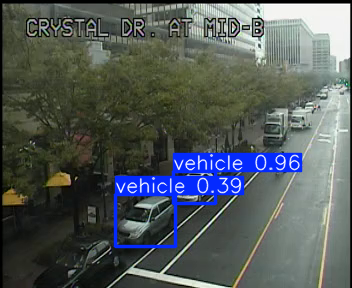

Test image 1: Detected 2 vehicles


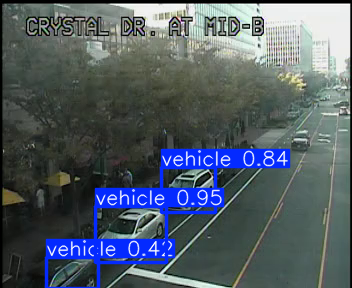

Test image 2: Detected 3 vehicles


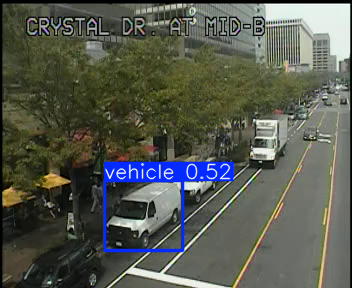

Test image 3: Detected 1 vehicles


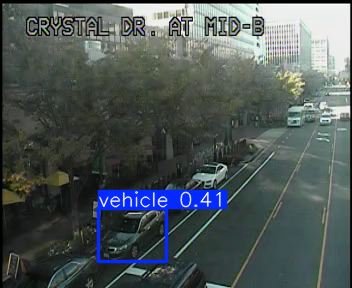

Test image 4: Detected 1 vehicles


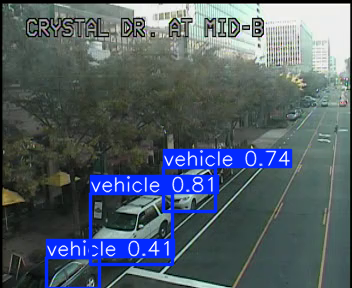

Test image 5: Detected 3 vehicles


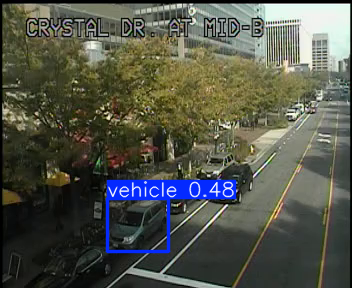

Test image 6: Detected 1 vehicles


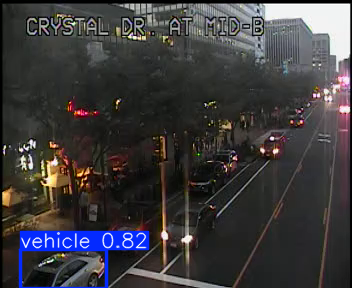

Test image 7: Detected 1 vehicles


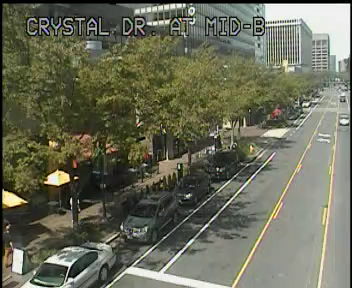

Test image 8: Detected 0 vehicles


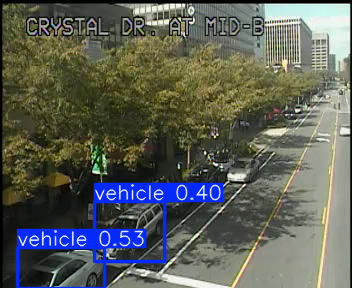

Test image 9: Detected 2 vehicles


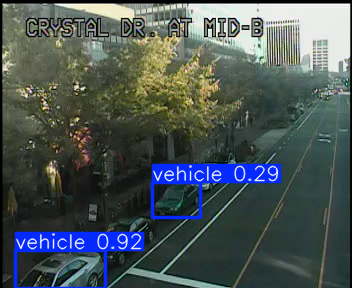

Test image 10: Detected 2 vehicles


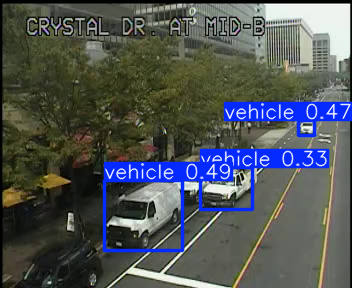

Test image 11: Detected 3 vehicles


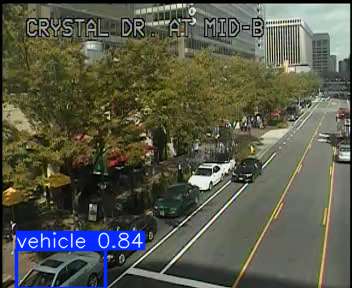

Test image 12: Detected 1 vehicles


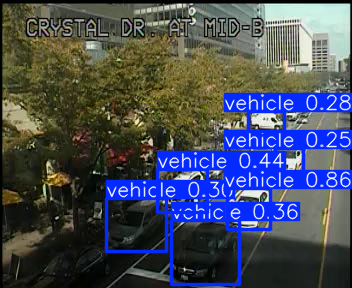

Test image 13: Detected 6 vehicles


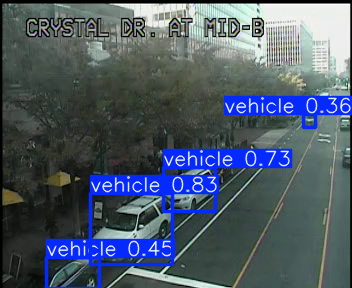

Test image 14: Detected 4 vehicles


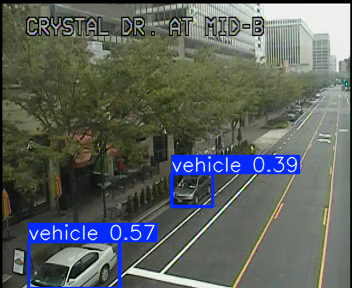

Test image 15: Detected 2 vehicles


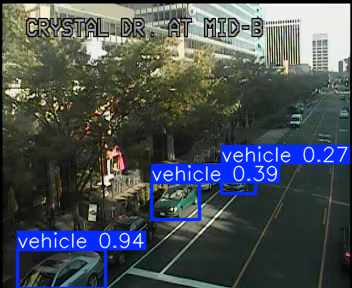

Test image 16: Detected 3 vehicles


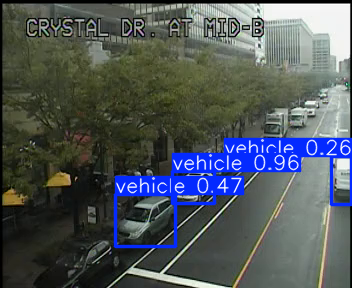

Test image 17: Detected 3 vehicles


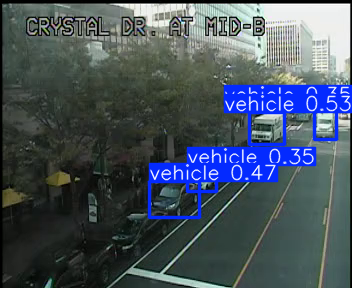

Test image 18: Detected 4 vehicles


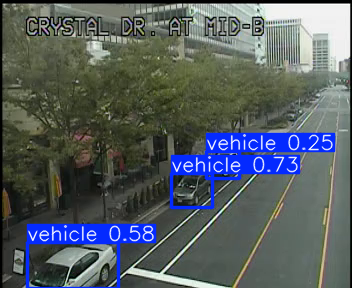

Test image 19: Detected 3 vehicles


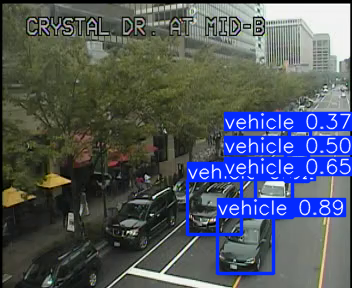

Test image 20: Detected 5 vehicles


In [29]:
test_data = test_imgs
test_results = best_model(test_data)

for i, result in enumerate(test_results[:20]):
    result.show()
    print(f"Test image {i+1}: Detected {len(result.boxes) if result.boxes else 0} vehicles")

## Method 2: Classification

Part 1: Train the model on the data split by camera

In [30]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")

model.train(
    data="/content/split_camera",
    epochs=20,
    imgsz=224,
)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/split_camera, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True,

ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7828f0131850>
curves: []
curves_results: []
fitness: 0.9578723311424255
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9157446622848511, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9578723311424255}
save_dir: PosixPath('/content/runs/classify/train')
speed: {'preprocess': 0.08199156000026708, 'inference': 0.25263140085158703, 'loss': 0.0003727259573157, 'postprocess': 0.00047222553145362097}
task: 'classify'
top1: 0.9157446622848511
top5: 1.0

Part 2: Evaluate model on validation set

In [31]:
def plot_confusion_matrix(cm, class_names):
    fig, ax = plt.subplots(figsize=(6, 5))
    cm = cm[:2, :2]
    im = ax.imshow(cm, cmap="Blues")

    # Show values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, f"{cm[i, j]:.0f}",
                    ha="center", va="center", color="black", fontsize=14)

    # Labels and ticks
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))

    ax.set_xticklabels([f"{c}" for c in class_names])
    ax.set_yticklabels([f"{c}" for c in class_names])

    ax.set_xlabel("Predicted", fontsize=14)
    ax.set_ylabel("Actual", fontsize=14)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("Count", rotation=270, labelpad=15)

    plt.title("Confusion Matrix", fontsize=16)
    plt.tight_layout()
    plt.show()

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,437,442 parameters, 0 gradients, 3.3 GFLOPs
train: /content/split_camera/train... found 2739 images in 2 classes ✅ 
val: /content/split_camera/val... found 1175 images in 2 classes ✅ 
test: /content/split_camera/test... found 38 images in 2 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 3000.9±1124.1 MB/s, size: 184.3 KB)
val: Scanning /content/split_camera/val... 1175 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1175/1175 2.8Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 74/74 57.9it/s 1.3s
                   all      0.915          1
Speed: 0.1ms preprocess, 0.6ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val
=========== VAL METRICS ===========
Top-1 Accuracy : 0.9149
Top-5 Accuracy : 1.0000
Fitness Score  : 0.9574

--- Raw Results Dict ---
metrics/accuracy_top1     

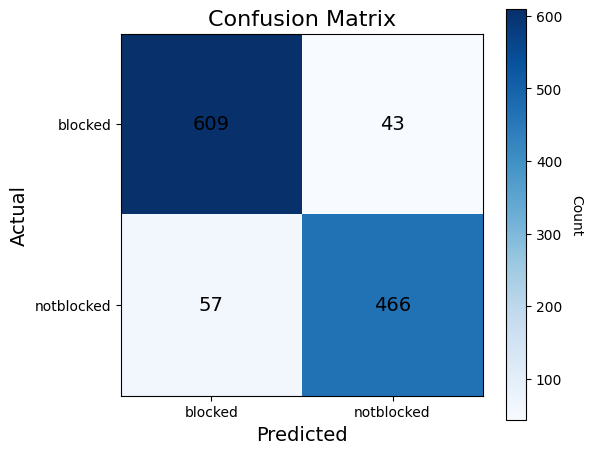

In [32]:
model = YOLO("/content/runs/classify/train/weights/best.pt")

val_results = model.val(
    data="/content/split_camera",
    split="val"
)

print("=========== VAL METRICS ===========")

print(f"Top-1 Accuracy : {val_results.top1:.4f}")
print(f"Top-5 Accuracy : {val_results.top5:.4f}")
print(f"Fitness Score  : {val_results.fitness:.4f}")

print("\n--- Raw Results Dict ---")
for k,v in val_results.results_dict.items():
    print(f"{k:25s} : {v:.4f}")

print("\nSpeed:")
for k,v in val_results.speed.items():
    print(f"{k:12s}: {v:.4f} ms")

print("\nConfusion Matrix:")
cm = val_results.confusion_matrix.matrix
class_names = ["blocked", "notblocked"]

plot_confusion_matrix(cm, class_names)

Part 3: Evaluate model on test set (unseen camera)

Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
train: /content/split_camera/train... found 2739 images in 2 classes ✅ 
val: /content/split_camera/val... found 1175 images in 2 classes ✅ 
test: /content/split_camera/test... found 38 images in 2 classes ✅ 
test: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2579.9±1285.8 MB/s, size: 174.1 KB)
test: Scanning /content/split_camera/test... 38 images, 0 corrupt: 100% ━━━━━━━━━━━━ 38/38 115.3Kit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 3/3 9.9it/s 0.3s
                   all      0.368          1
Speed: 1.3ms preprocess, 1.8ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val4
=========== TEST METRICS ===========
Top-1 Accuracy : 0.3684
Top-5 Accuracy : 1.0000
Fitness Score  : 0.6842

--- Raw Results Dict ---
metrics/accuracy_top1     : 0.3684
metrics/accuracy_top5     : 1.0000
fitness                   : 0.6842

Speed:
p

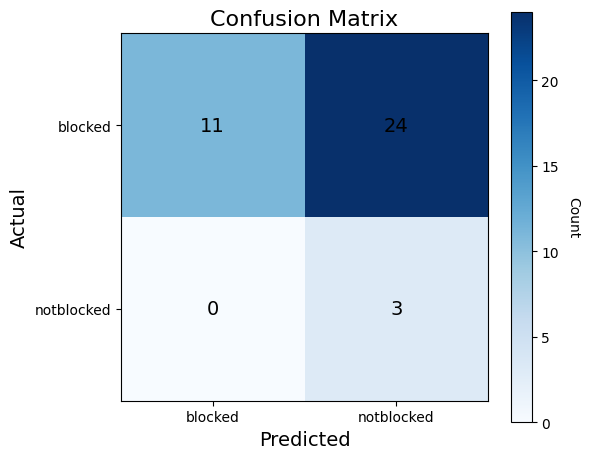

In [35]:
test_results = model.val(
    data="/content/split_camera",
    split="test"
)

print("=========== TEST METRICS ===========")

print(f"Top-1 Accuracy : {test_results.top1:.4f}")
print(f"Top-5 Accuracy : {test_results.top5:.4f}")
print(f"Fitness Score  : {test_results.fitness:.4f}")

print("\n--- Raw Results Dict ---")
for k,v in test_results.results_dict.items():
    print(f"{k:25s} : {v:.4f}")

print("\nSpeed:")
for k,v in test_results.speed.items():
    print(f"{k:12s}: {v:.4f} ms")

print("\nConfusion Matrix:")
cm = test_results.confusion_matrix.matrix
class_names = ["blocked", "notblocked"]

plot_confusion_matrix(cm, class_names)